In [1]:
import pandas, numpy, qnorm, seaborn

In [2]:
import scipy, scipy.signal
import sklearn, sklearn.preprocessing, sklearn.decomposition

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.90, 9 * 0.90)})

# user-defined variables

In [4]:
input_dir = '/Users/adrian/research/vigur/data/metabolomics/targeted/'

basic_input_file = 'EC008_ROSA_PMVEC_INTRA_BASIC.xlsx'
positive_input_file = 'EC008_ROSA_PMVEC_INTRA_POS.xlsx'
negative_input_file = 'EC008_ROSA_PMVEC_INTRA_NEG.xlsx'

input_files = [positive_input_file, negative_input_file, basic_input_file]
ion_modes = ['positive', 'negative', 'basic']

# read metadata

In [5]:
path = input_dir + basic_input_file
metadata = pandas.read_excel(input_dir+positive_input_file, sheet_name=0, index_col=1)

new_labels = [element.split('_')[0] for element in metadata.index.values]
rosetta = dict(zip(metadata.index.values, new_labels))
metadata.rename(index=rosetta, inplace=True)
metadata.head()

Sample  Sample ID BioReplicate Timepoint µM catech  \
Label                                                                       
Pool1   PMUEC_INTRA_EC008_103  Pool1_pos            -         -         -   
Pool1   PMUEC_INTRA_EC008_104  Pool1_pos            -         -         -   
Pool1   PMUEC_INTRA_EC008_105  Pool1_pos            -         -         -   
Pool2   PMUEC_INTRA_EC008_107  Pool2_pos            -         -         -   
008-02  PMUEC_INTRA_EC008_109      008-2            1         0         0   

       TecRep TNFalpha LPS cell number      LCMS Method  \
Label                                                     
Pool1       -        -   -           -  HILIC_POS_10min   
Pool1       -        -   -           -  HILIC_POS_10min   
Pool1       -        -   -           -  HILIC_POS_10min   
Pool2       -        -   -           -  HILIC_POS_10min   
008-02      2        0   0       80000  HILIC_POS_10min   

        LCMS Analytical Order  LCMS BATCH  
Label                                      
Pool1                       1           1  
Pool1                       2           1  
Pool1                       3           1  
Pool2                       4           1  
008-02                      5           1

# broadly exploring distributions

In [6]:
def pca_plotter(df, info):
    
    new_labels = [element.split('_')[0] for element in df.columns.values]
    rosetta = dict(zip(df.columns.values, new_labels))
    df.rename(columns=rosetta, inplace=True)  

    wdf = df.transpose()
    scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(wdf)
    model = sklearn.decomposition.PCA(n_components=2)
    locations = model.fit_transform(scaled_data)
    explained = model.explained_variance_ratio_
    
    for j in range(len(locations)):
        label = wdf.index[j]
        
        #
        # treatment
        #
        if 'A' in label:
            if metadata.loc[label, 'TNFalpha'] == 10:
                treatment = 'TNF'
            elif metadata.loc[label, 'LPS'] == 10:
                treatment = 'LPS'
            else:
                treatment = 0
        elif 'ool' in label:
            treatment = 'Pool'
        else:
            treatment = metadata.loc[label, 'µM catech']
            
        if treatment == 'TNF':
            the_color = 'tab:green'
        elif treatment == 'LPS':
            the_color = 'skyblue'
        elif treatment == 'Pool':
            the_color = 'gold'; the_marker = 'D'
        elif treatment == 0:
            the_color = 'black'
        elif treatment == 5:
            the_color = 'tab:red'
        else:
            print(treatment)
            raise ValueError('unknown treatment')
    
        #
        # timepoint
        #
        if treatment != 'Pool':
            timepoint = metadata.loc[label, 'Timepoint']
            if timepoint == 0:
                the_marker = 'X'
            elif timepoint == 4:
                the_marker = 'o'
            elif timepoint == 24:
                the_marker = 's'
            else:
                raise ValueError('unknown timepoint')
    
        #
        # replicate
        #
        replicate = metadata.loc[label, 'BioReplicate']
        
        #
        # plot
        # 
        matplotlib.pyplot.scatter(locations[j, 0], locations[j, 1], s=500, c=the_color, marker=the_marker, alpha=2/3, edgecolors='none')
        if the_color == 'gold':
            pass
        else:
            matplotlib.pyplot.text(locations[j, 0], locations[j, 1], replicate, fontsize=8, color='white', ha='center', va='center', weight='bold')
    # legend
    legend_elements = [ 
        matplotlib.patches.Patch(facecolor='black', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='tab:red', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='tab:green', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='skyblue', edgecolor='white', alpha=2/3),
        matplotlib.patches.Patch(facecolor='gold', edgecolor='white', alpha=2/3),

        matplotlib.lines.Line2D([0], [0], color='white', marker='X', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], color='white', marker='s', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], color='white', marker='D', markerfacecolor='white', markeredgecolor='black', markersize=20, alpha=2/3)
    ]
    matplotlib.pyplot.legend(legend_elements, 
                             ['control', 'epi:nor', 'TNFa', 'LPS', 'Pool', 't=0', 't=4h', 't=24h', 'Pool'], 
                             ncol=1, loc=1, 
                             bbox_to_anchor=(1.2, 1, 0.1, 0.1))

    matplotlib.pyplot.xlabel('PC1 (exp. var.: {}%)'.format(int(explained[0]*100)))
    matplotlib.pyplot.ylabel('PC2 (exp. var.: {}%)'.format(int(explained[1]*100)))
    matplotlib.pyplot.title(ion_modes[i] + info)
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    #matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    return None

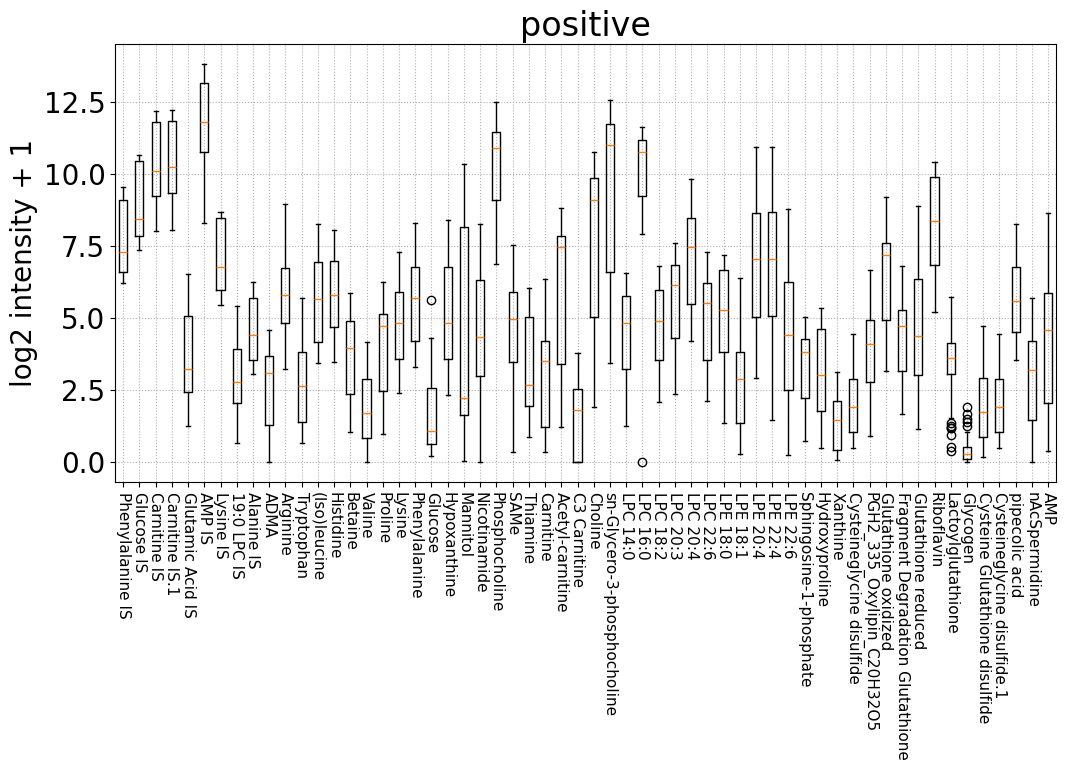

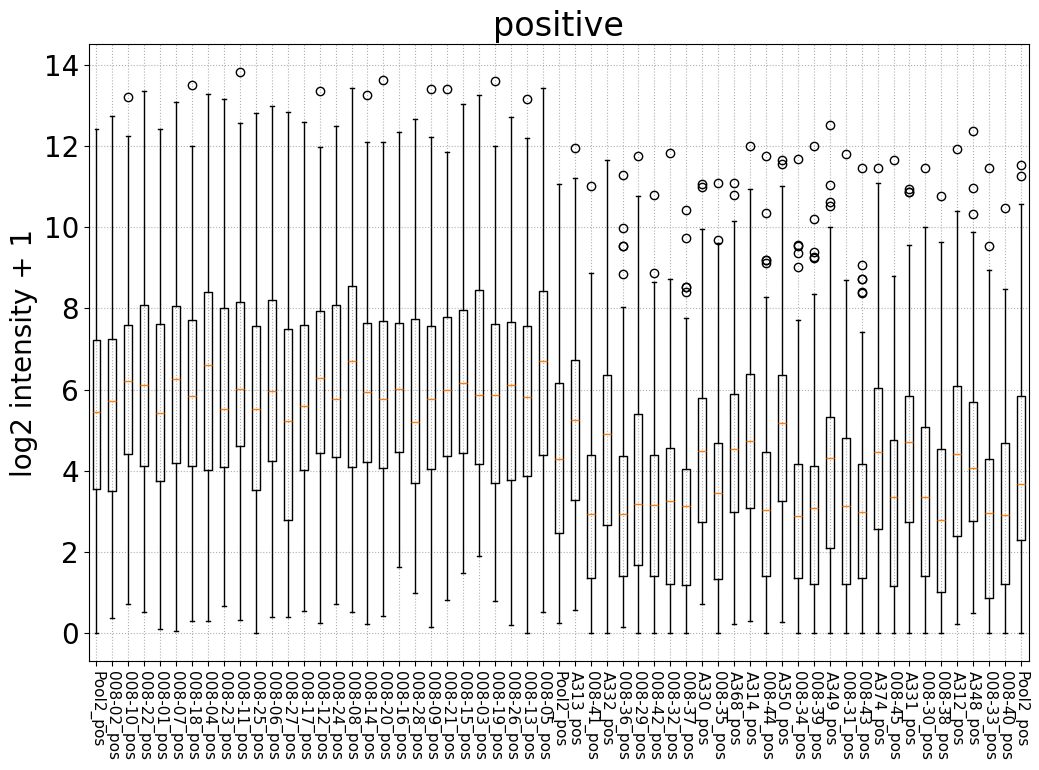

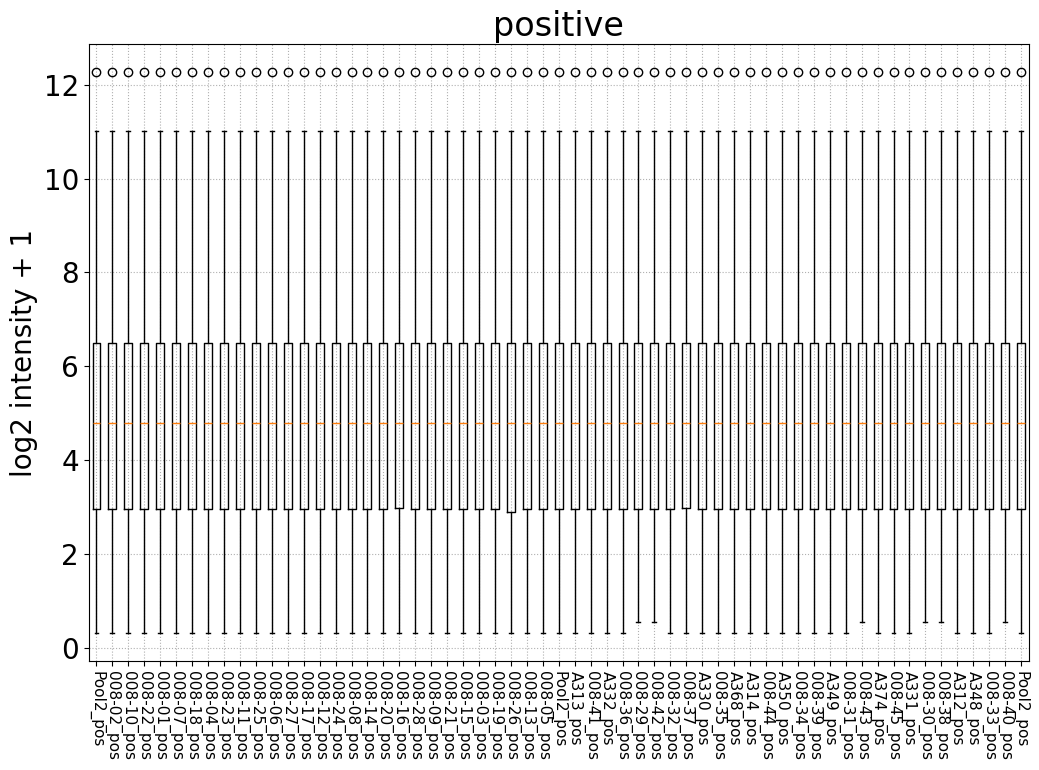

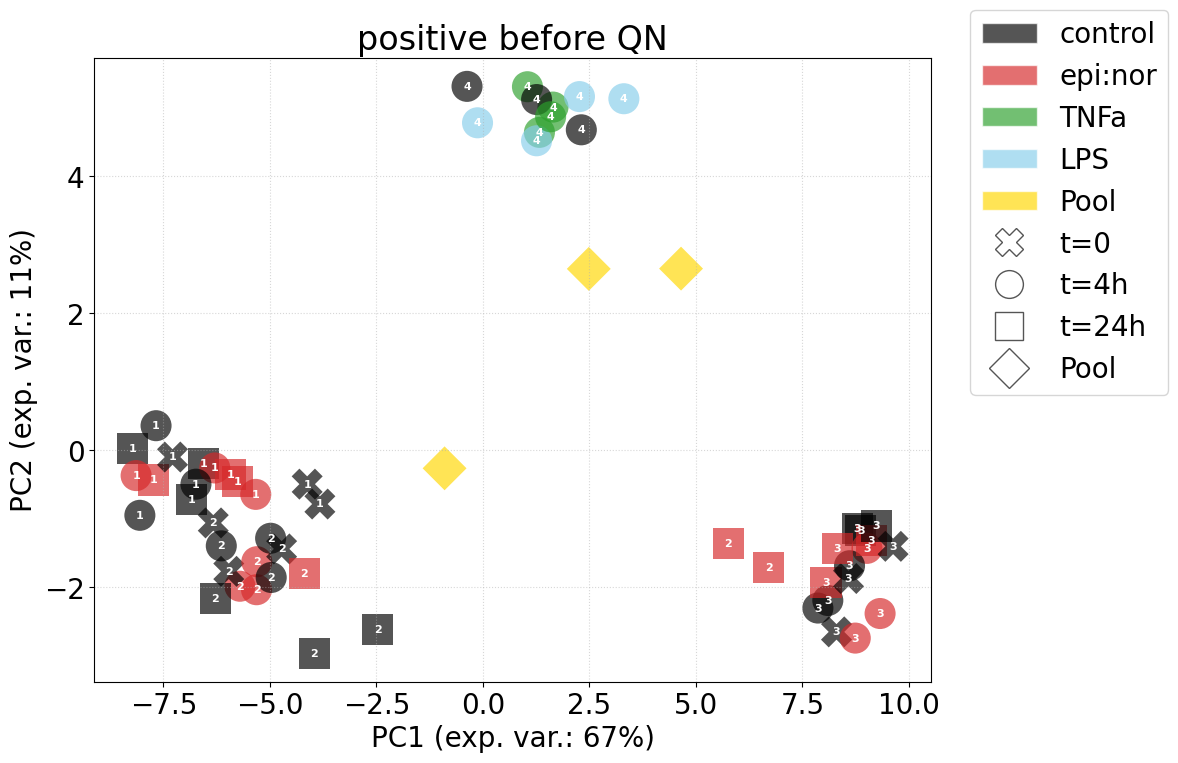

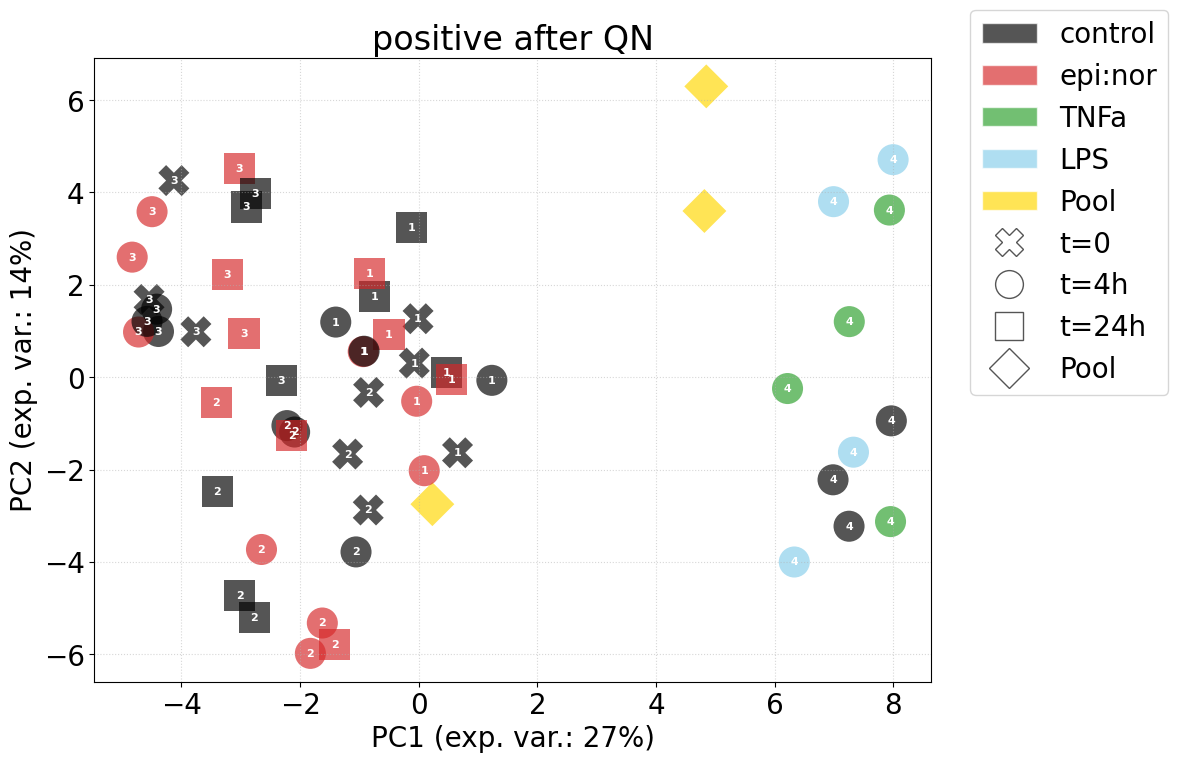

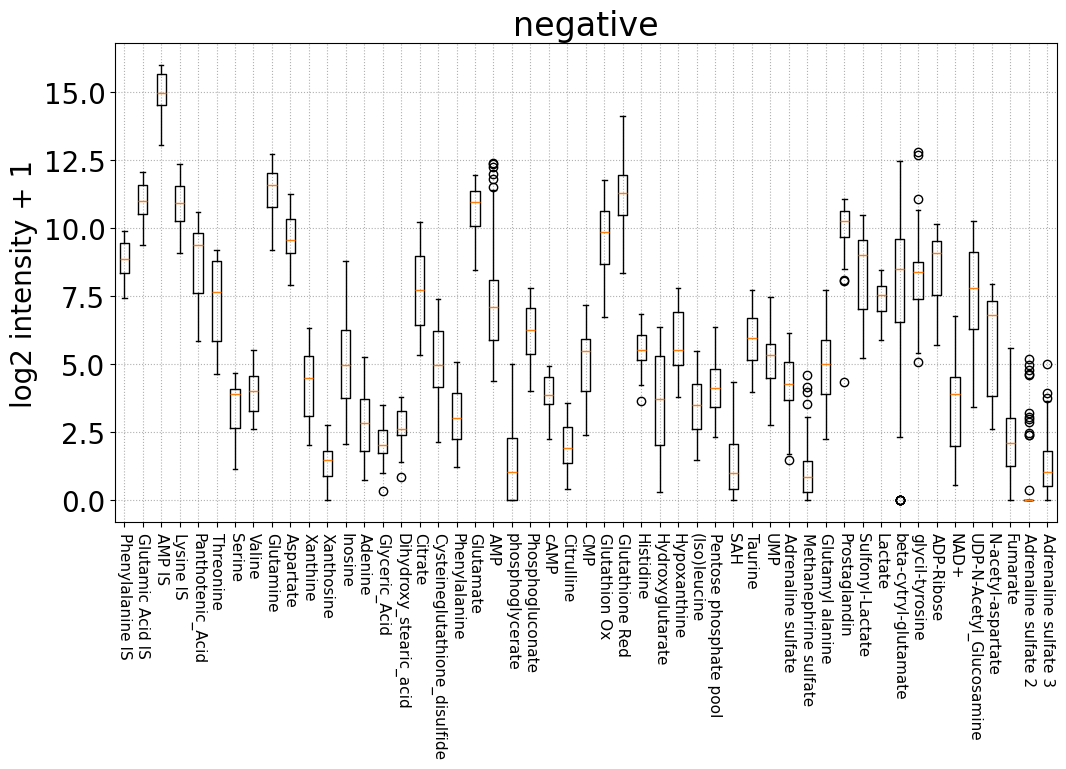

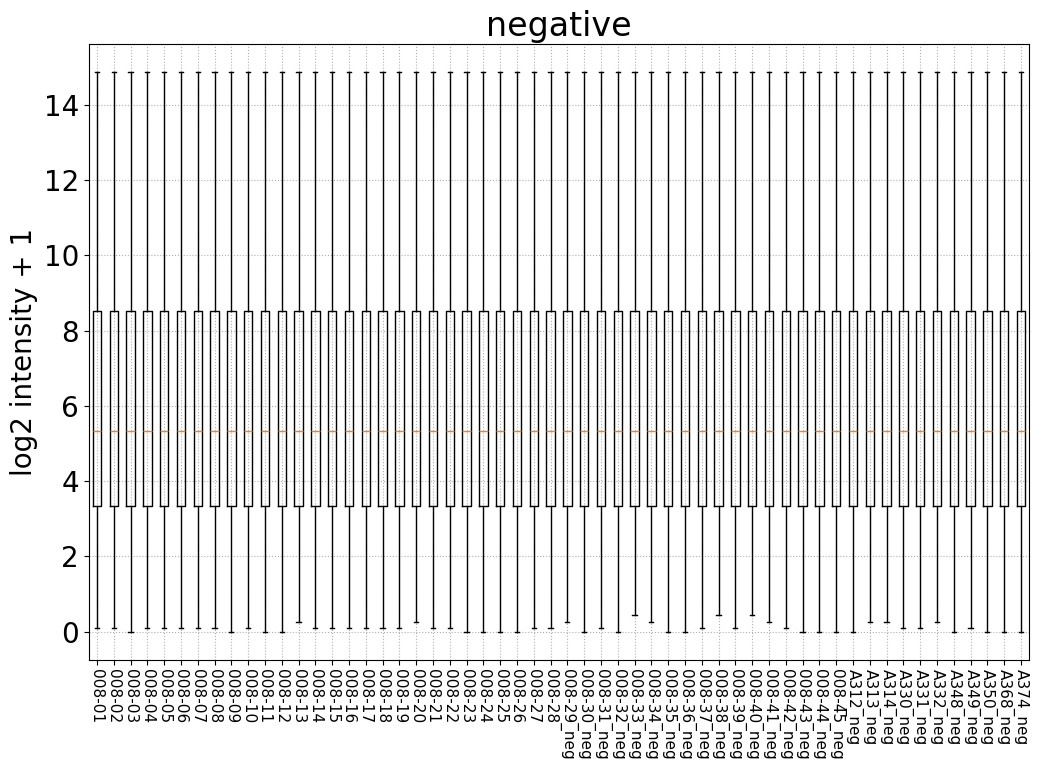

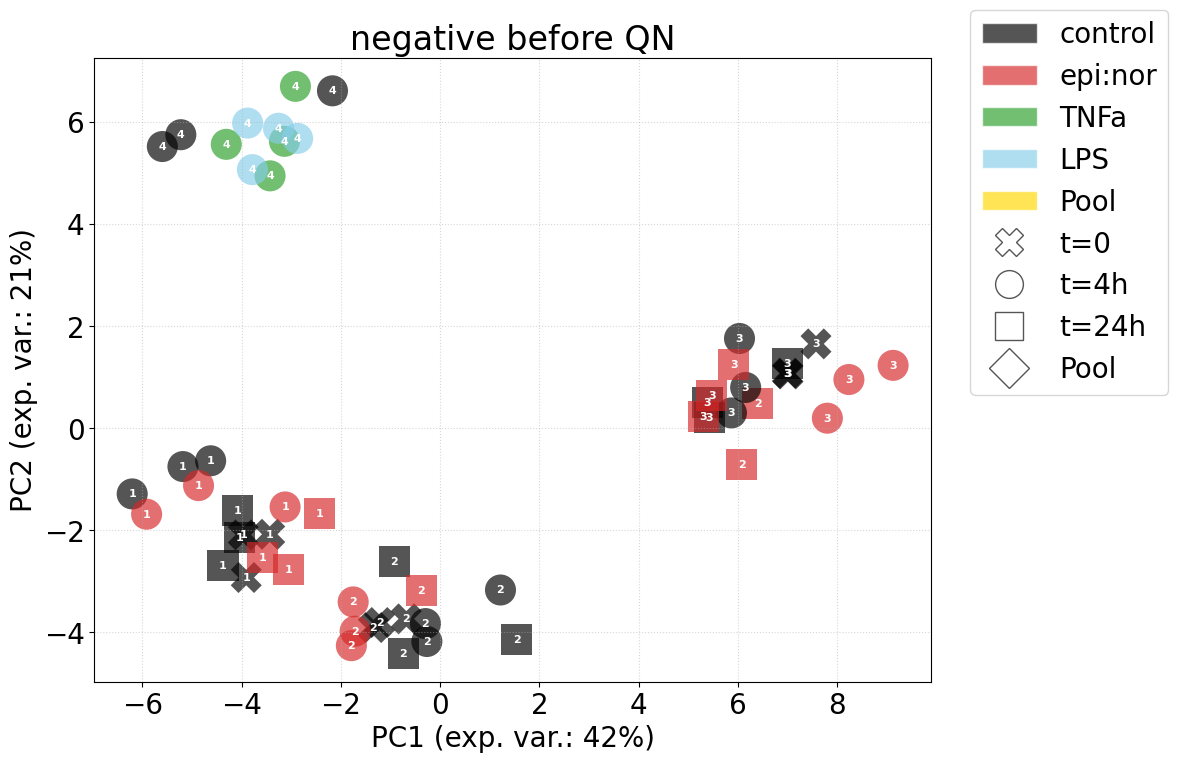

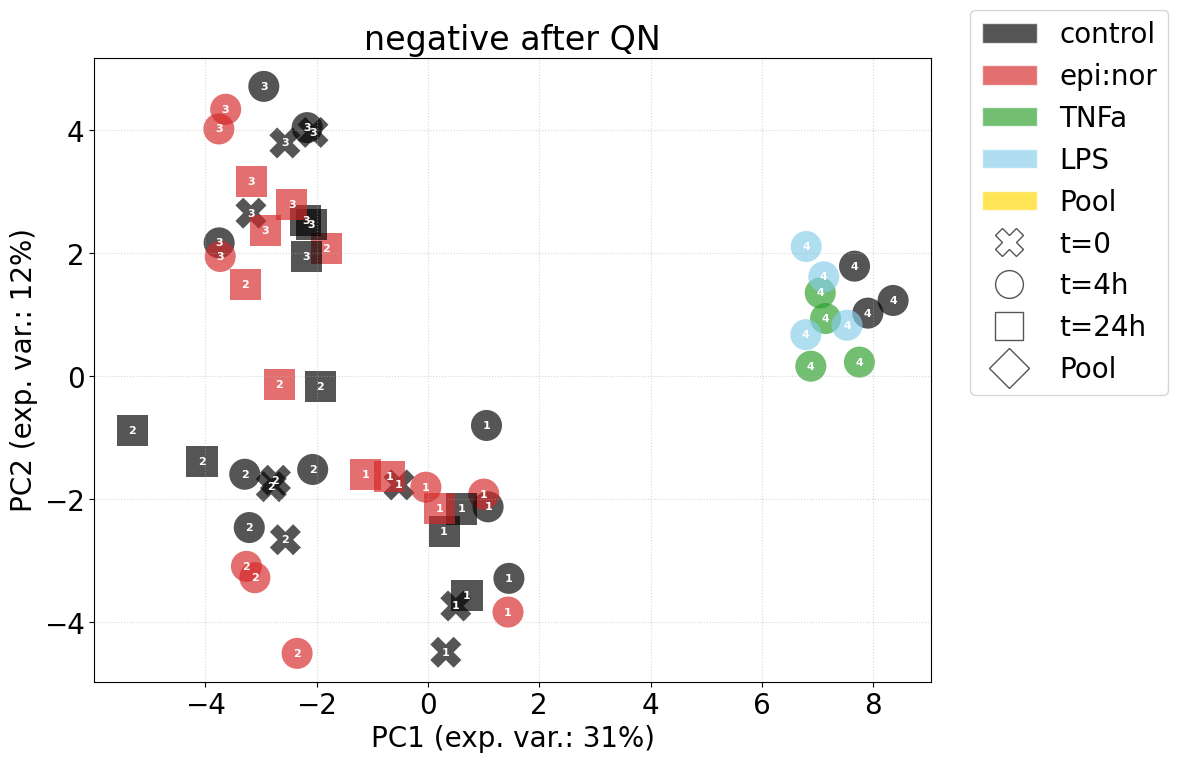

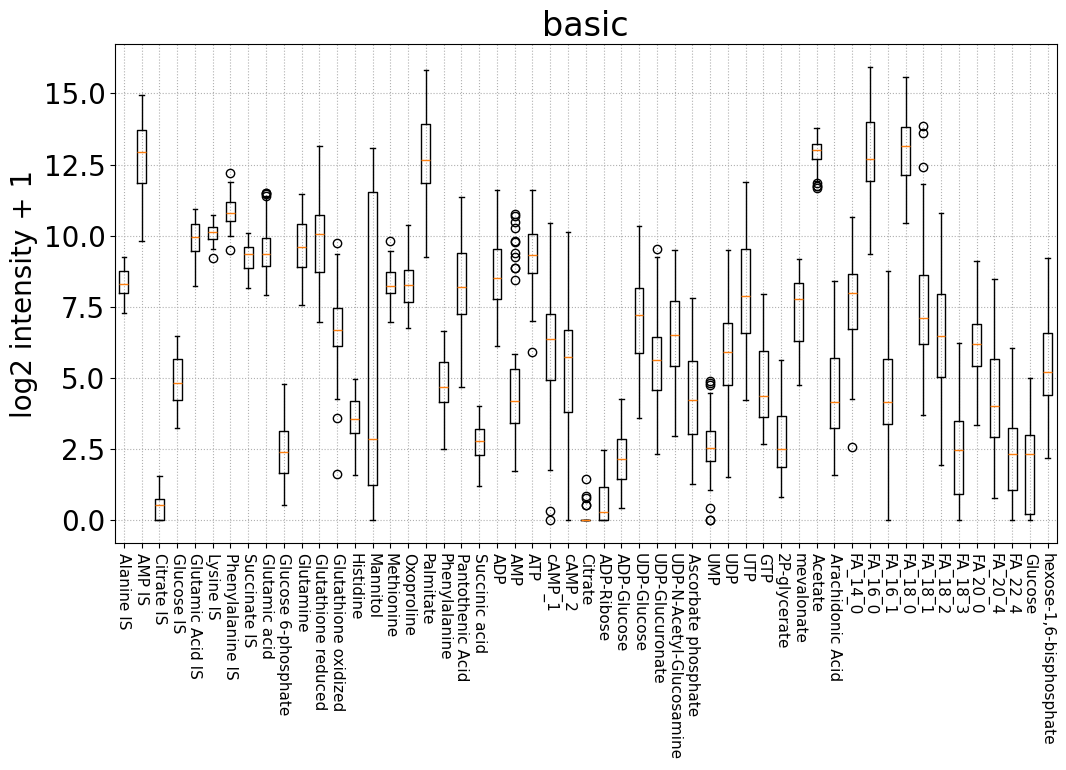

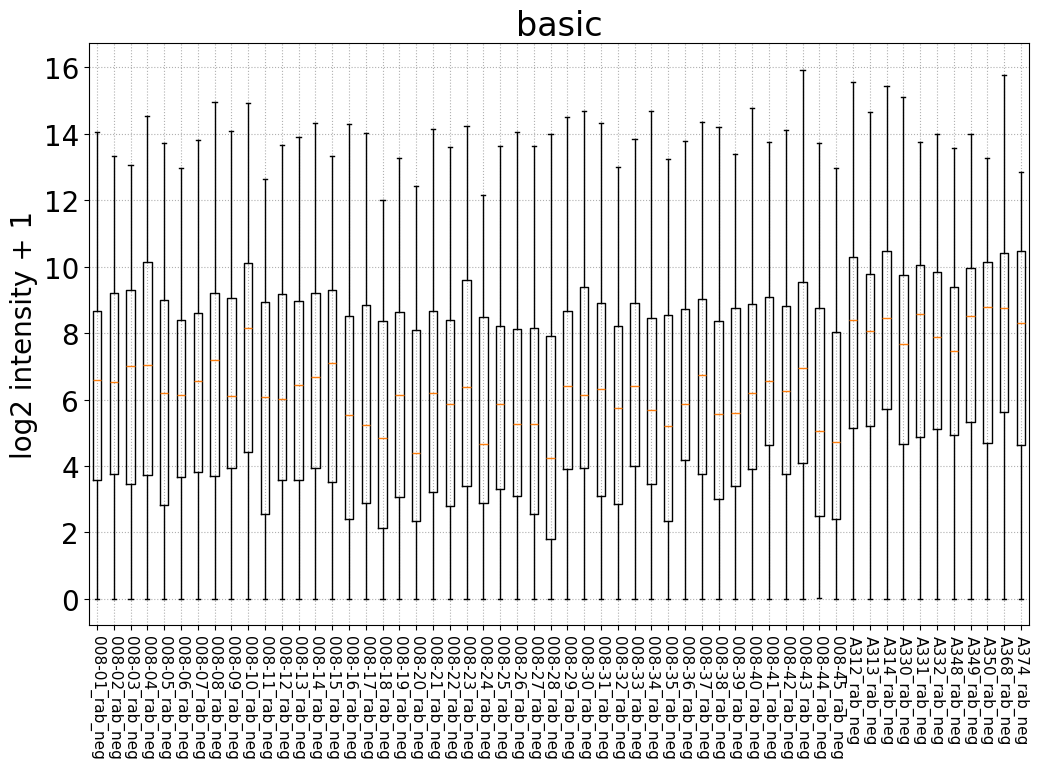

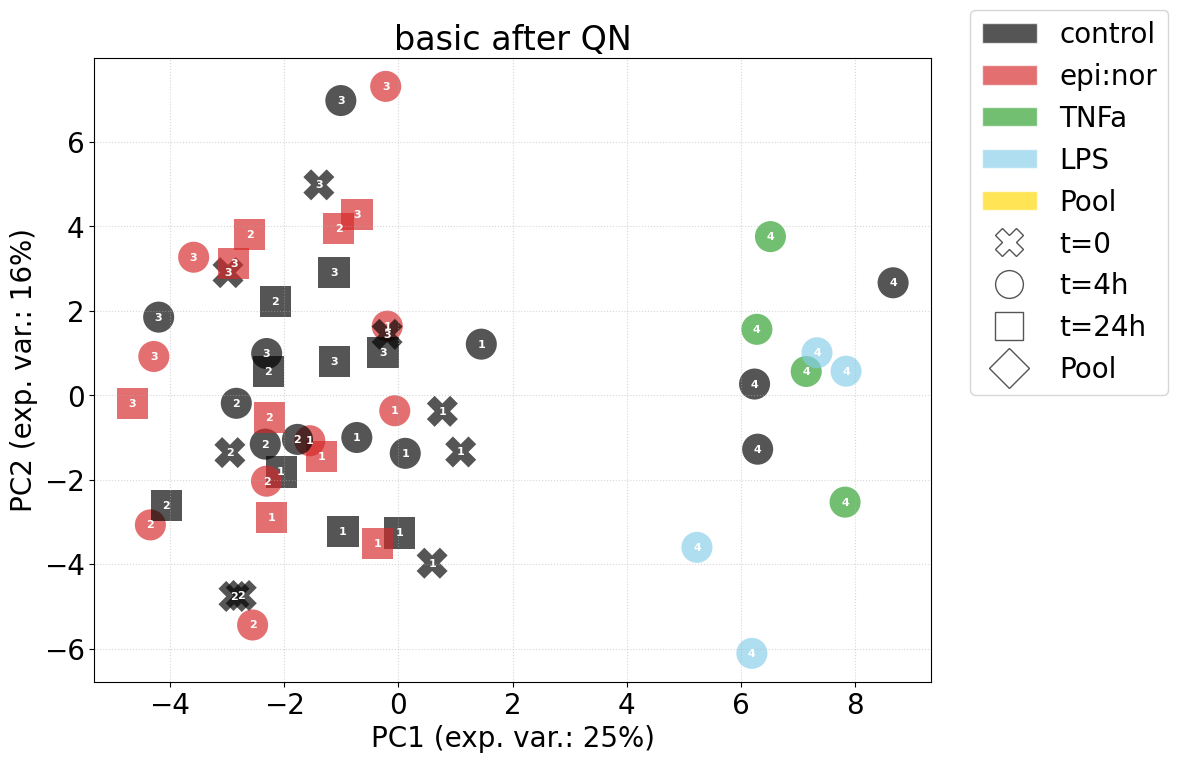

In [7]:
all_dfs = []
for i in range(len(input_files)):

    input_file = input_files[i]
    ion_mode = ion_modes[i]
    
    path = input_dir + input_file
    df = pandas.read_excel(path, sheet_name=1, index_col=0)
    
    log2intensity = numpy.log2(df+1)

    #
    # display metabolite distributions
    #
    matplotlib.pyplot.boxplot(log2intensity)

    matplotlib.pyplot.xticks(range(1,len(df.columns)+1), df.columns, rotation=-90, fontsize=11)
    matplotlib.pyplot.ylabel('log2 intensity + 1')

    matplotlib.pyplot.title(ion_mode)
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    #
    # show sample distributions
    #
    log_df = numpy.log2(df+1)
    transpose = log2intensity.transpose()

    matplotlib.pyplot.boxplot(transpose)
    matplotlib.pyplot.xticks(range(1,len(transpose.columns)+1), transpose.columns, rotation=-90, fontsize=11)
    matplotlib.pyplot.ylabel('log2 intensity + 1')
    matplotlib.pyplot.title(ion_mode)
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    #
    # perform quantile normalization
    #
    qndf = qnorm.quantile_normalize(transpose, axis=1)
    all_dfs.append(qndf)

    matplotlib.pyplot.boxplot(qndf)
    matplotlib.pyplot.xticks(range(1,len(qndf.columns)+1), qndf.columns, rotation=-90, fontsize=11)
    matplotlib.pyplot.ylabel('log2 intensity + 1')
    matplotlib.pyplot.title(ion_mode)
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    #
    # pca
    #
    pca_plotter(transpose, ' before QN')
    pca_plotter(qndf, ' after QN')

The conclusion from these figures is that:
- quantification units are intensities.
- quantification is not quantitative.
- we need quantile normalization.
- Biological replicate and not treatment is the largest source of variation.
- Quantile normalization does not fix previous point.

# visualize metabolites across conditions

In [8]:
## violin plots

In [9]:
wdf = all_dfs[0]

In [10]:
metadata

Sample  Sample ID BioReplicate Timepoint µM catech  \
Label                                                                       
Pool1   PMUEC_INTRA_EC008_103  Pool1_pos            -         -         -   
Pool1   PMUEC_INTRA_EC008_104  Pool1_pos            -         -         -   
Pool1   PMUEC_INTRA_EC008_105  Pool1_pos            -         -         -   
Pool2   PMUEC_INTRA_EC008_107  Pool2_pos            -         -         -   
008-02  PMUEC_INTRA_EC008_109      008-2            1         0         0   
...                       ...        ...          ...       ...       ...   
A312    PMUEC_INTRA_EC008_243   A312_neg            4         4         0   
A348    PMUEC_INTRA_EC008_244   A348_neg            4         4         0   
008-33  PMUEC_INTRA_EC008_245     008-33            3         0         0   
008-40  PMUEC_INTRA_EC008_246     008-40            3        24         0   
Pool2   PMUEC_INTRA_EC008_248  Pool2_pos            -         -         -   

       TecRep TNFalpha LPS cell number      LCMS Method  \
Label                                                     
Pool1       -        -   -           -  HILIC_POS_10min   
Pool1       -        -   -           -  HILIC_POS_10min   
Pool1       -        -   -           -  HILIC_POS_10min   
Pool2       -        -   -           -  HILIC_POS_10min   
008-02      2        0   0       80000  HILIC_POS_10min   
...       ...      ...  ..         ...              ...   
A312        1        0   0      300000  HILIC_POS_10min   
A348        1        0  10      300000  HILIC_POS_10min   
008-33      3        0   0       25000  HILIC_POS_10min   
008-40      1        0   0       40000  HILIC_POS_10min   
Pool2       -        -   -           -  HILIC_POS_10min   

        LCMS Analytical Order  LCMS BATCH  
Label                                      
Pool1                       1           1  
Pool1                       2           1  
Pool1                       3           1  
Pool2                       4           1  
008-02                      5           1  
...                       ...         ...  
A312                       33           2  
A348                       34           2  
008-33                     35           2  
008-40                     36           2  
Pool2                      37           2  

[74 rows x 12 columns]

In [11]:
rules = (metadata['Timepoint'] == 0) & (metadata['BioReplicate'] == 1)    
metadata[rules]

Sample Sample ID BioReplicate Timepoint µM catech  \
Label                                                                      
008-02  PMUEC_INTRA_EC008_109     008-2            1         0         0   
008-01  PMUEC_INTRA_EC008_112     008-1            1         0         0   
008-03  PMUEC_INTRA_EC008_144     008-3            1         0         0   

       TecRep TNFalpha LPS cell number      LCMS Method  \
Label                                                     
008-02      2        0   0       80000  HILIC_POS_10min   
008-01      1        0   0       80000  HILIC_POS_10min   
008-03      3        0   0       80000  HILIC_POS_10min   

        LCMS Analytical Order  LCMS BATCH  
Label                                      
008-02                      5           1  
008-01                      8           1  
008-03                     32           1

In [22]:
results.pvalue

0.8270357976579235

Phenylalanine IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)
	 significance at 4 h



Glucose IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


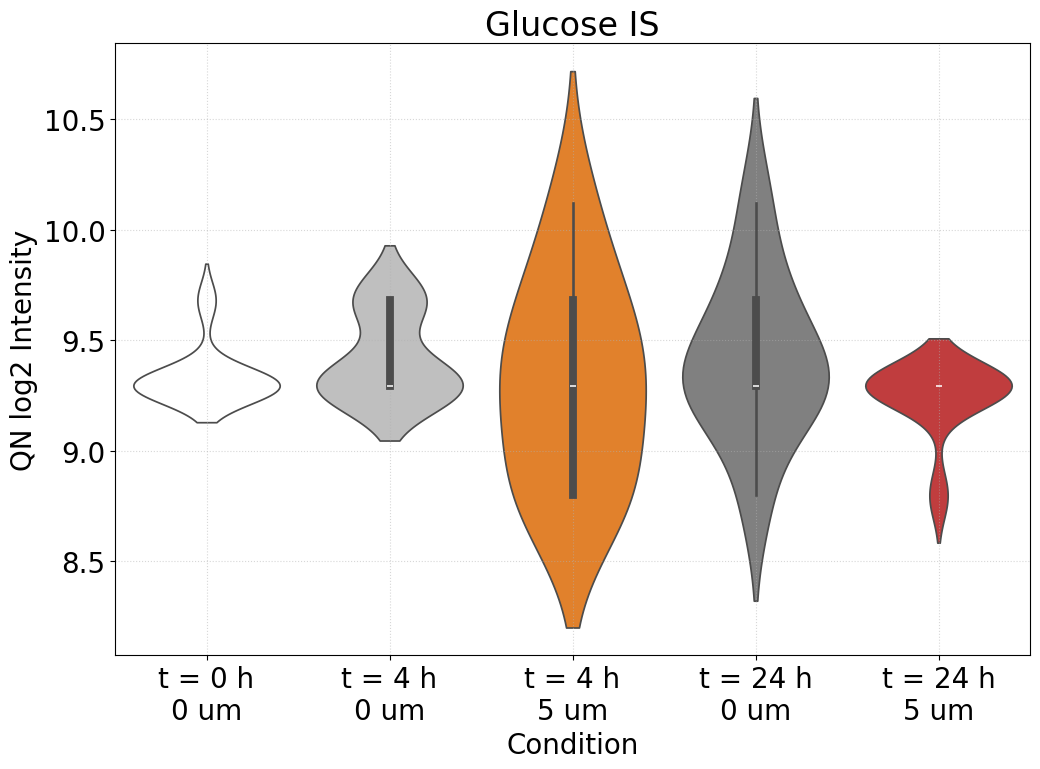


Carnitine IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


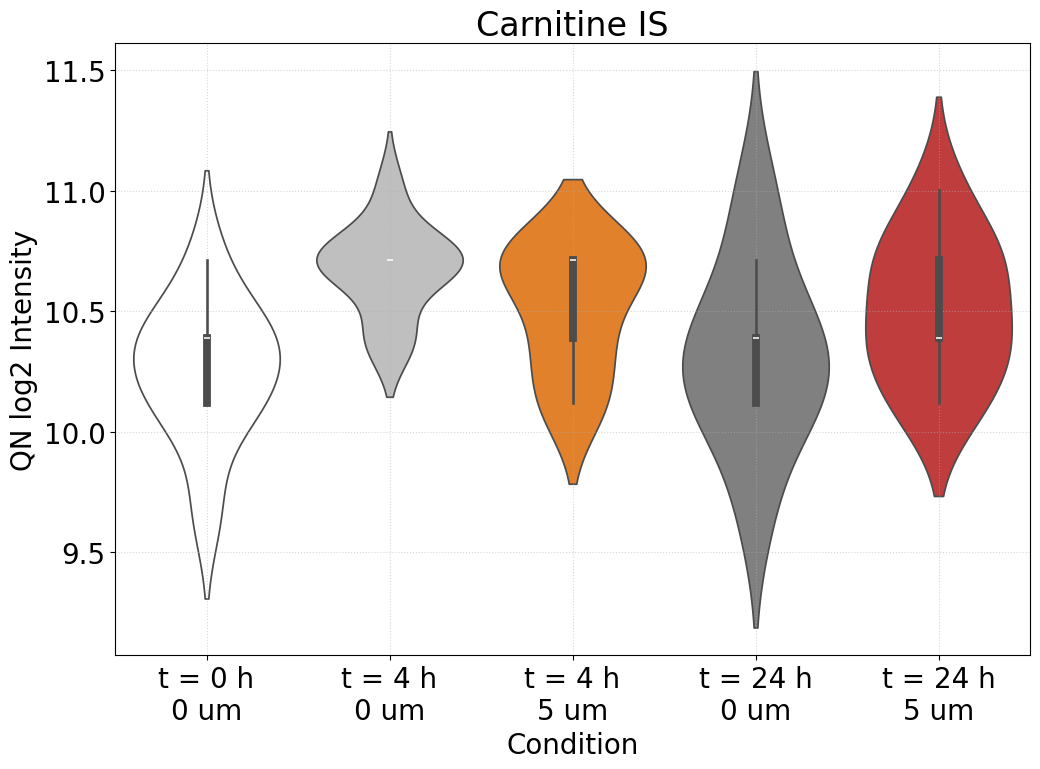


Carnitine IS.1
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


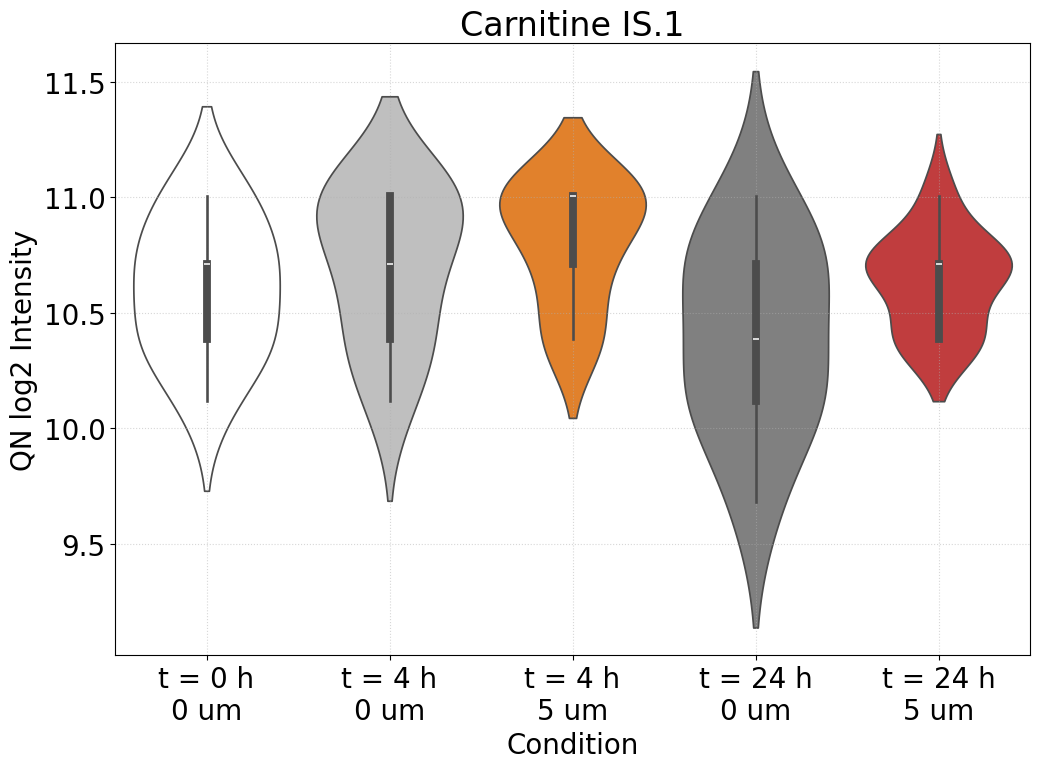


Glutamic Acid IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


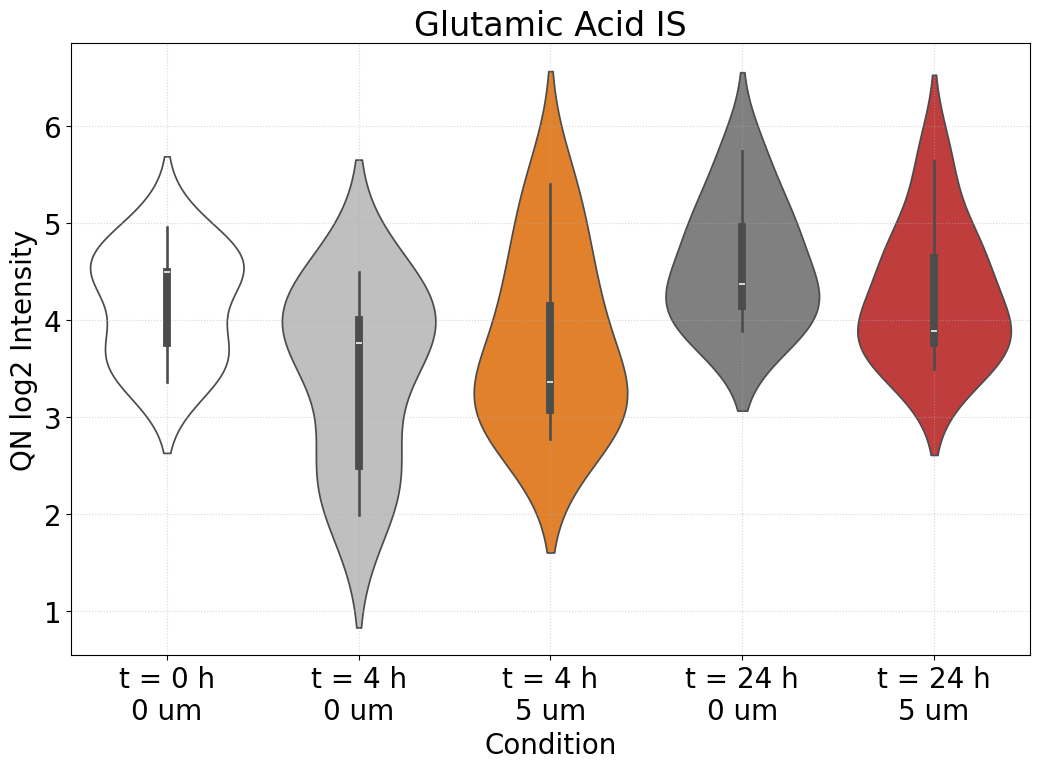


AMP IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


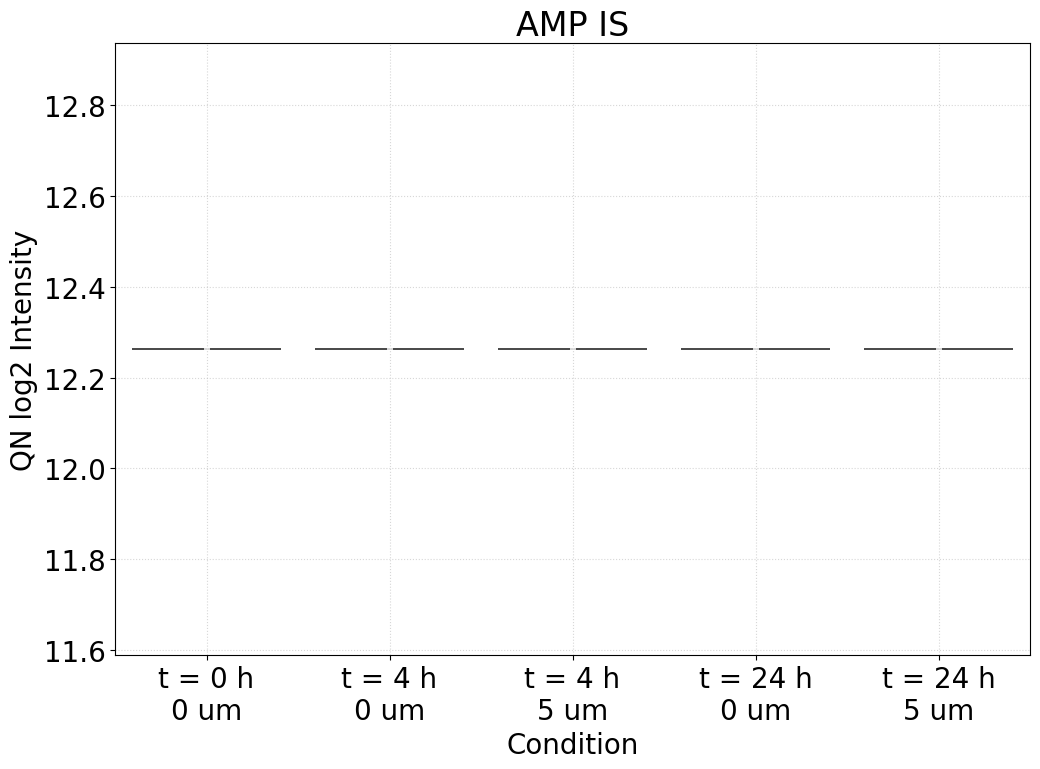


Lysine IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


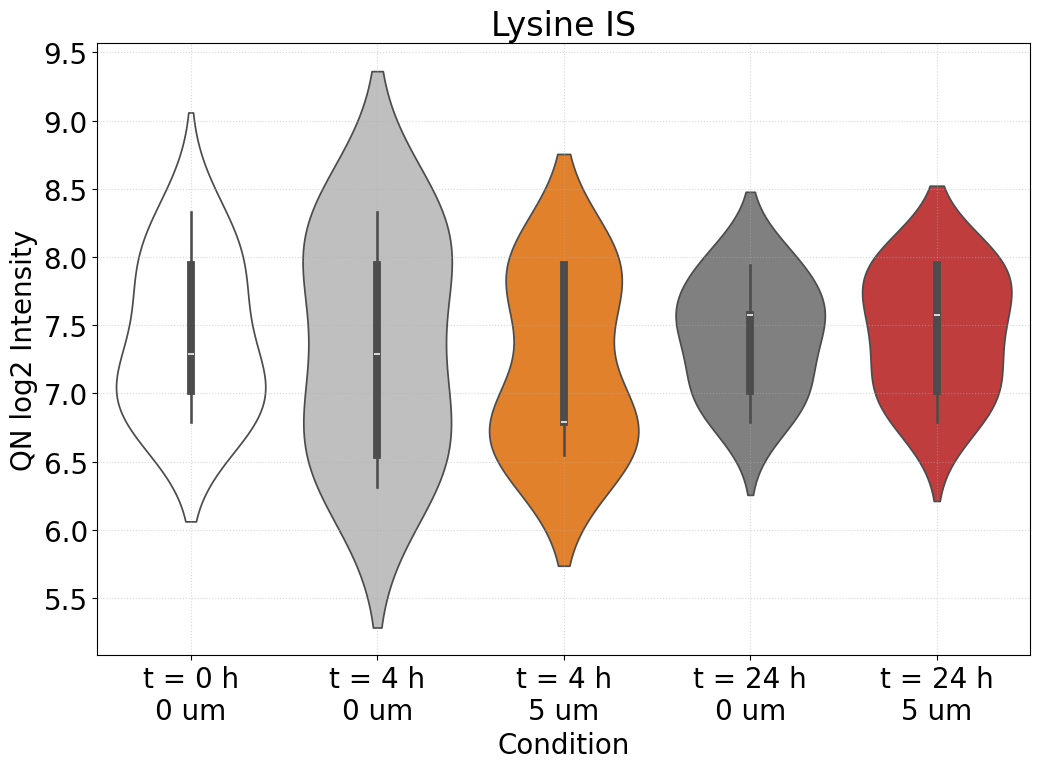


19:0 LPC IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


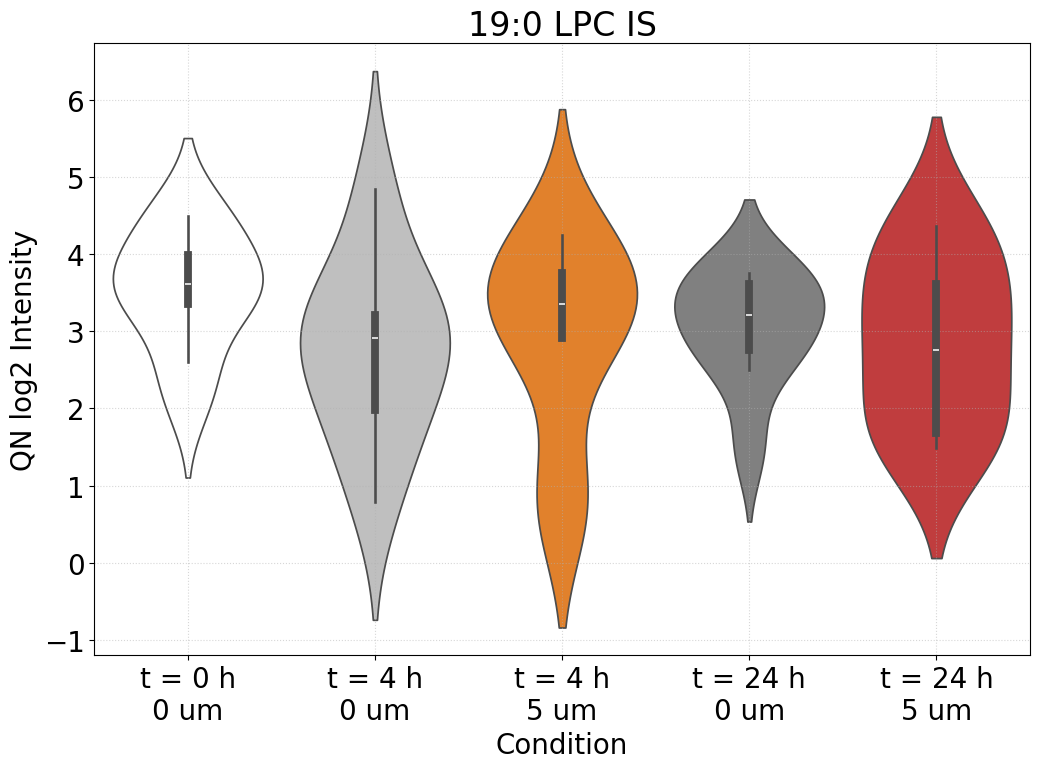


Alanine IS
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



ADMA
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


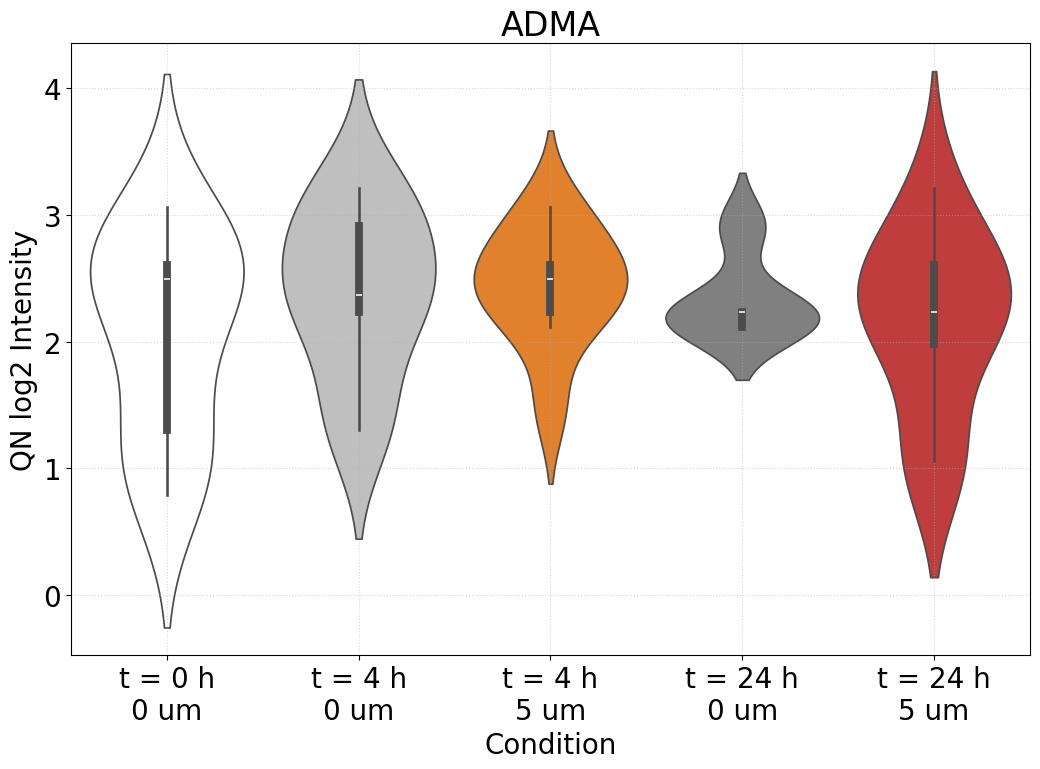


Arginine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



Tryptophan
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


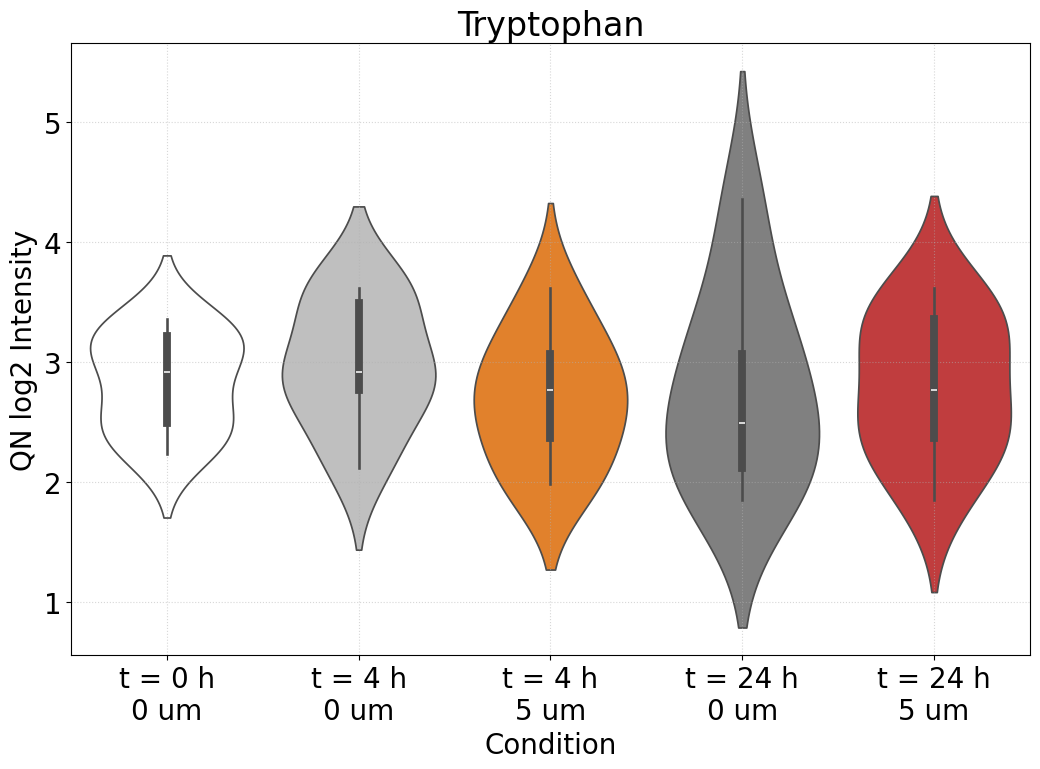


(Iso)leucine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


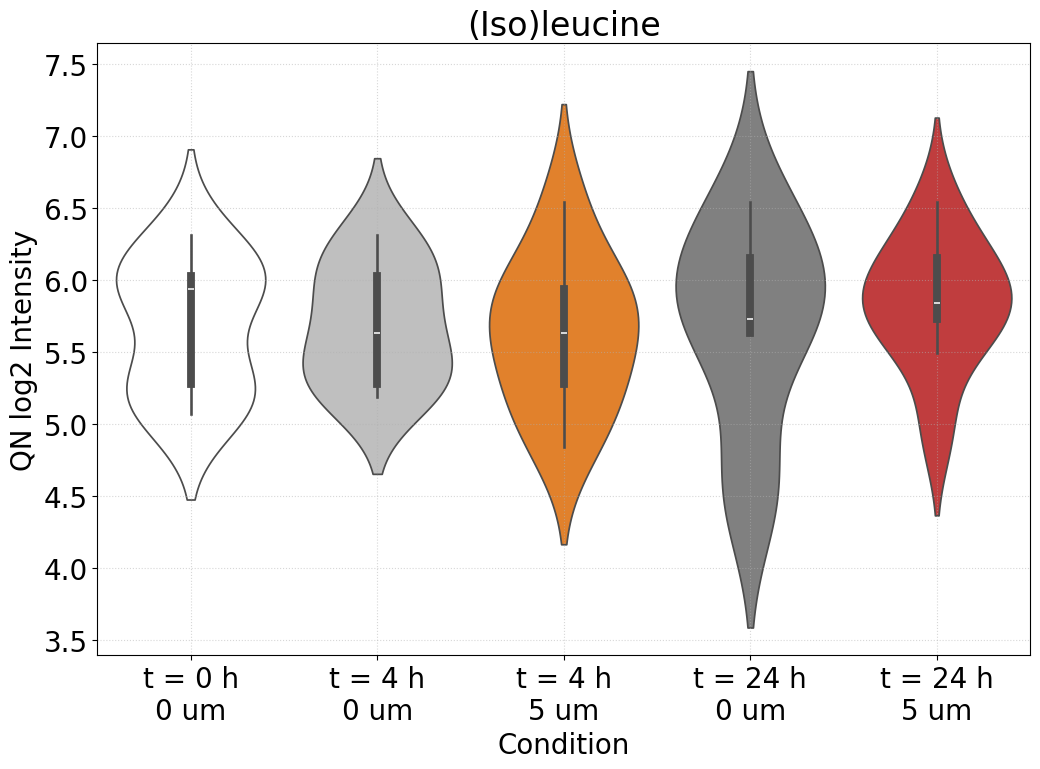


Histidine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


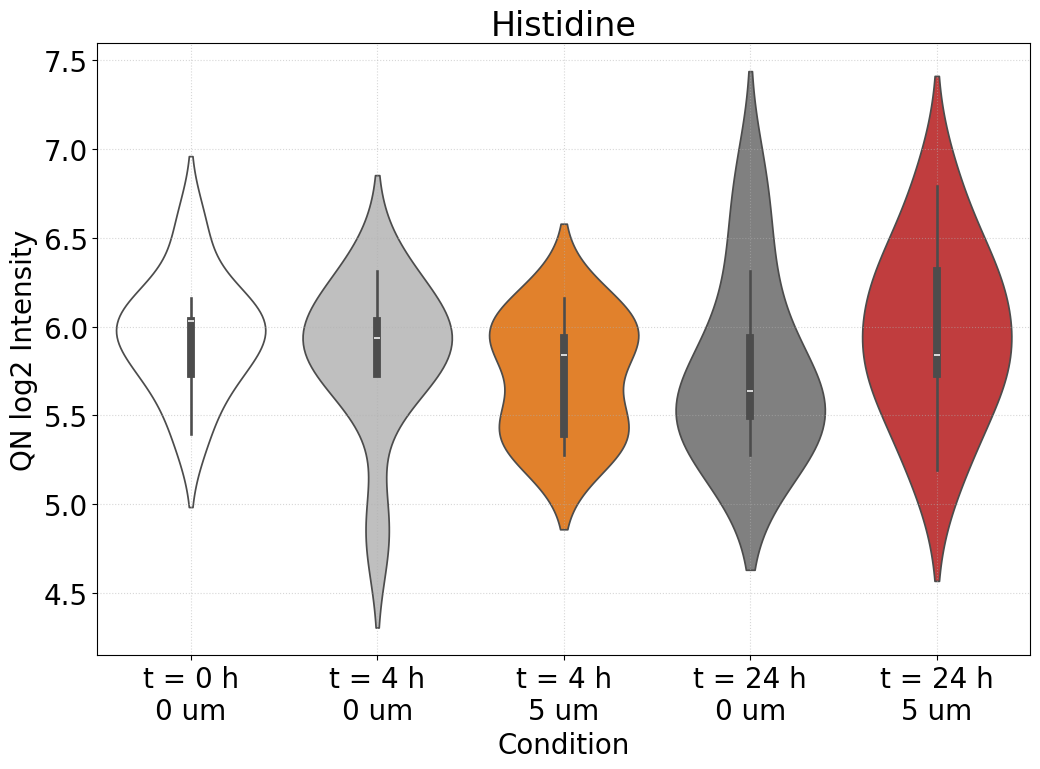


Betaine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


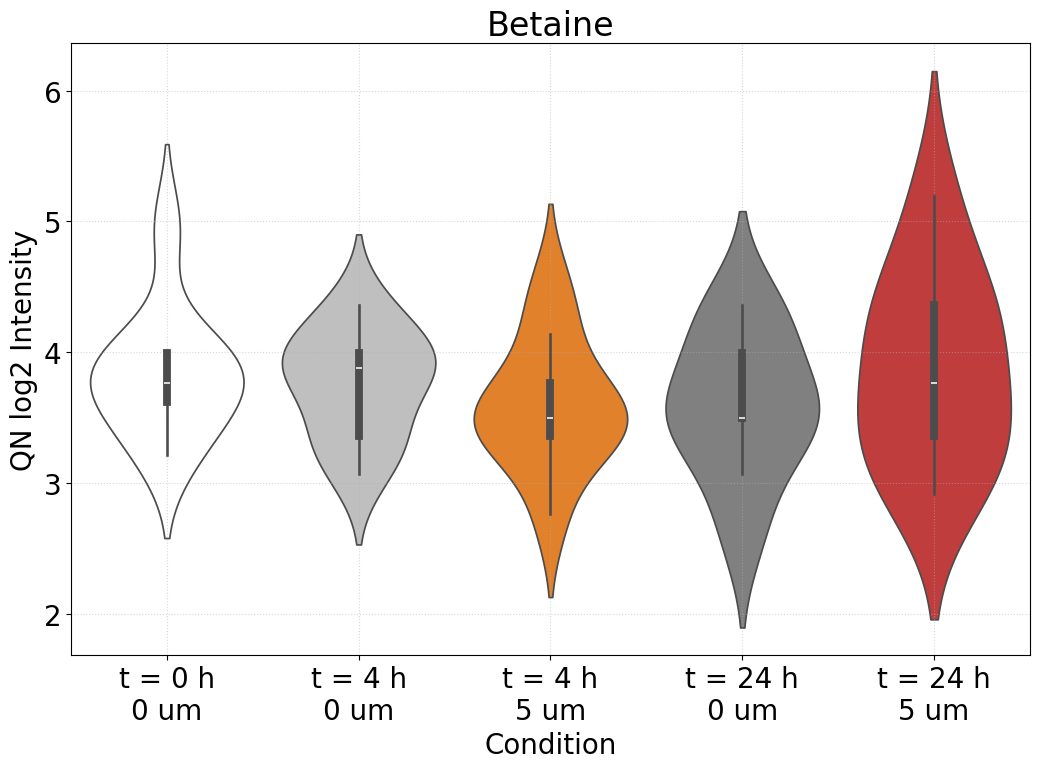


Valine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)
	 significance at 4 h


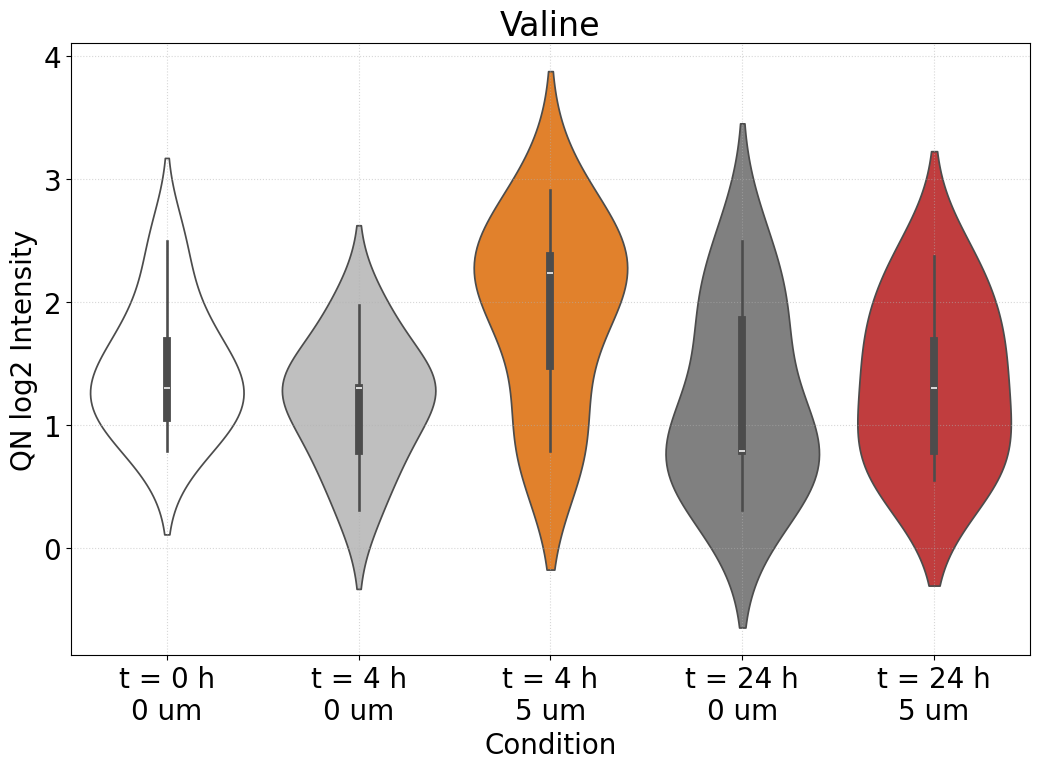


Proline
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


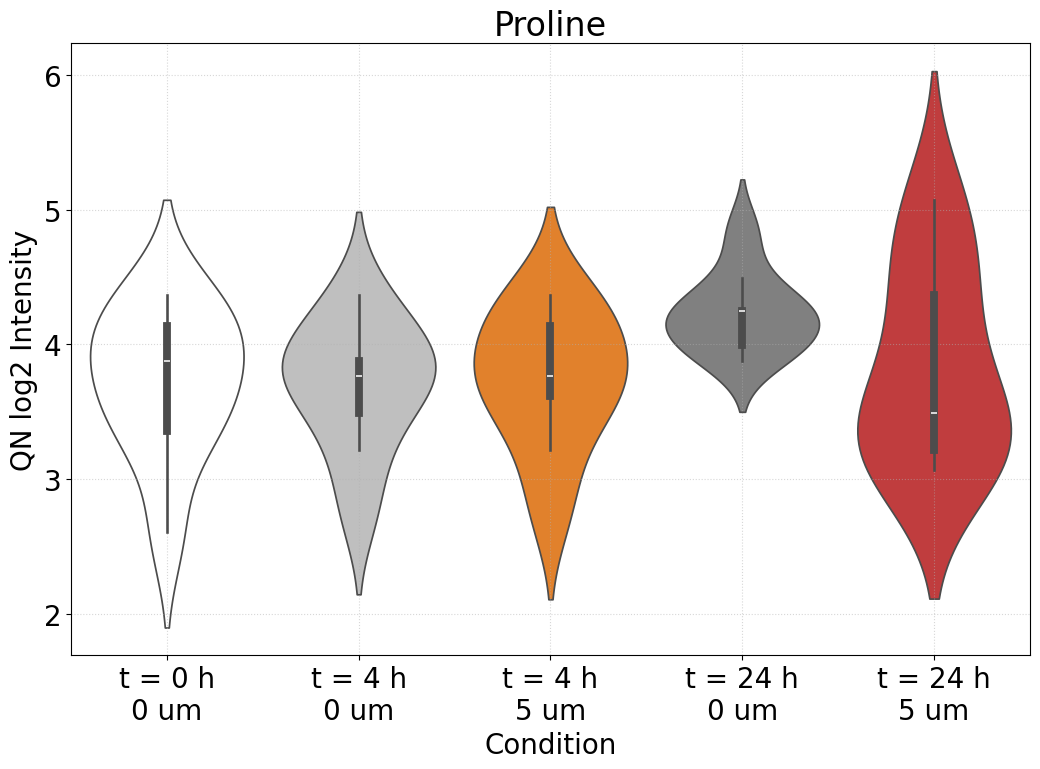


Lysine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



Phenylalanine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


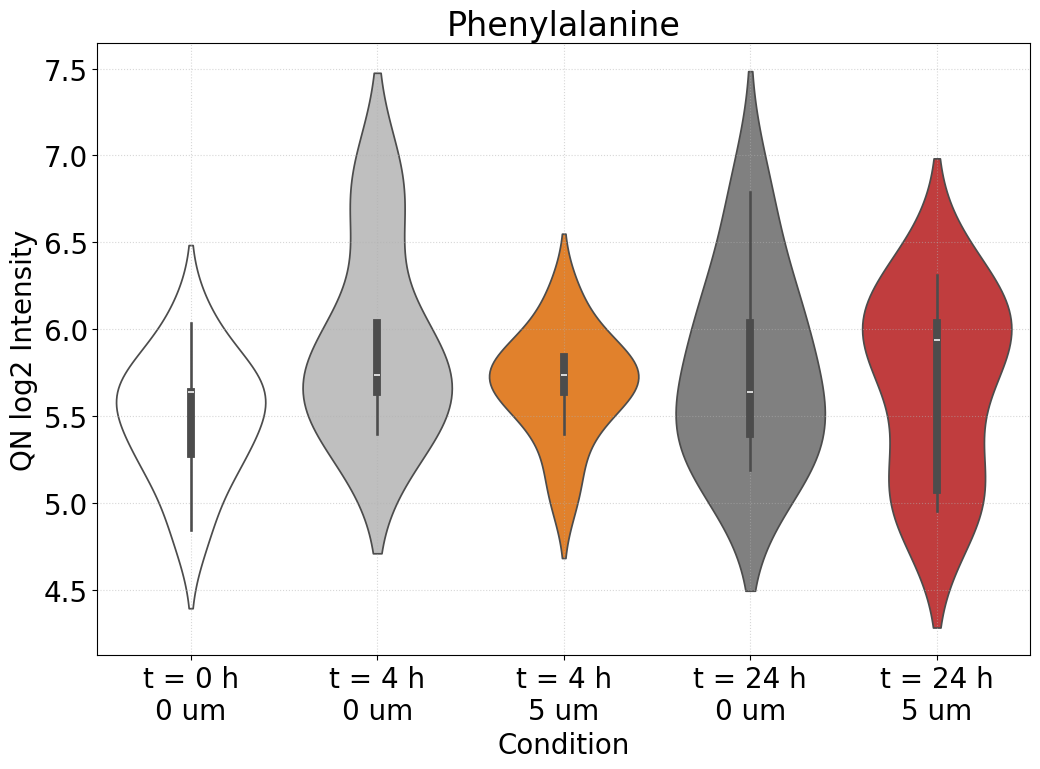


Glucose
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



Hypoxanthine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


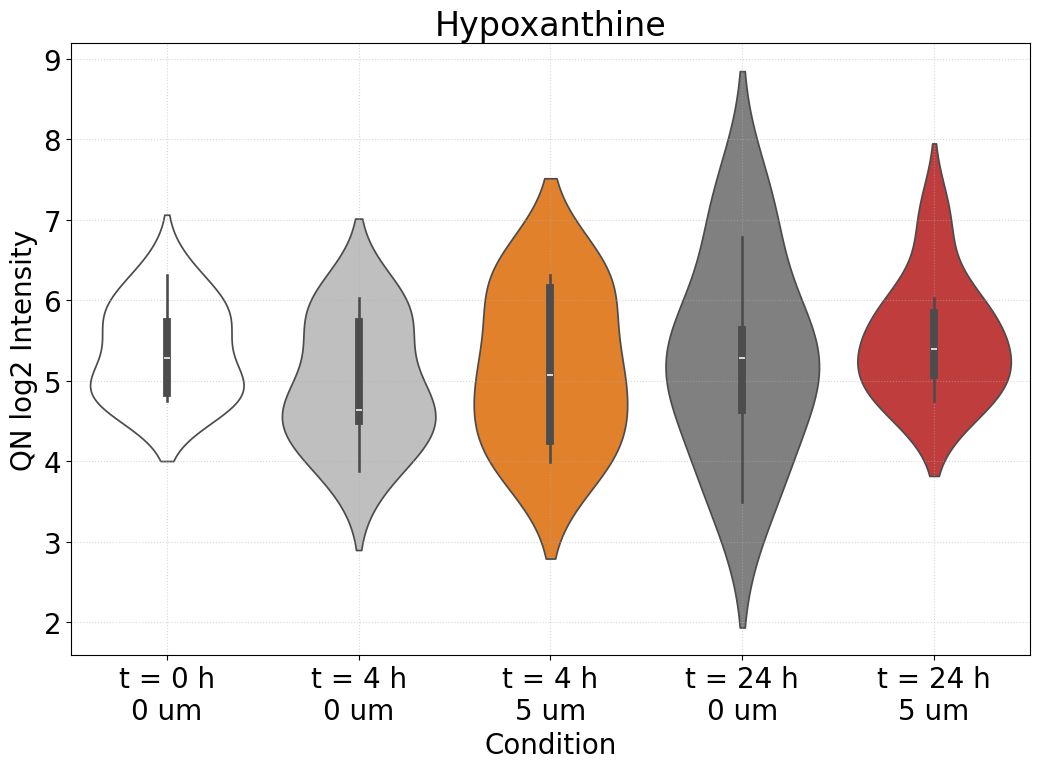


Mannitol
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



Nicotinamide
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


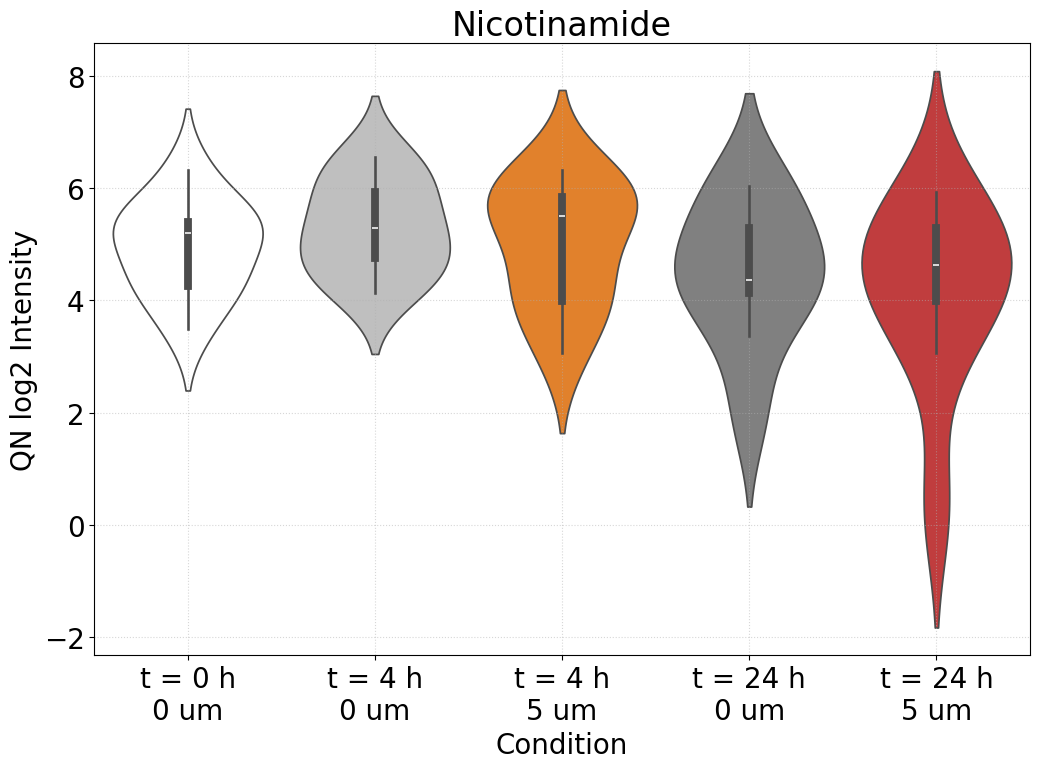


Phosphocholine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


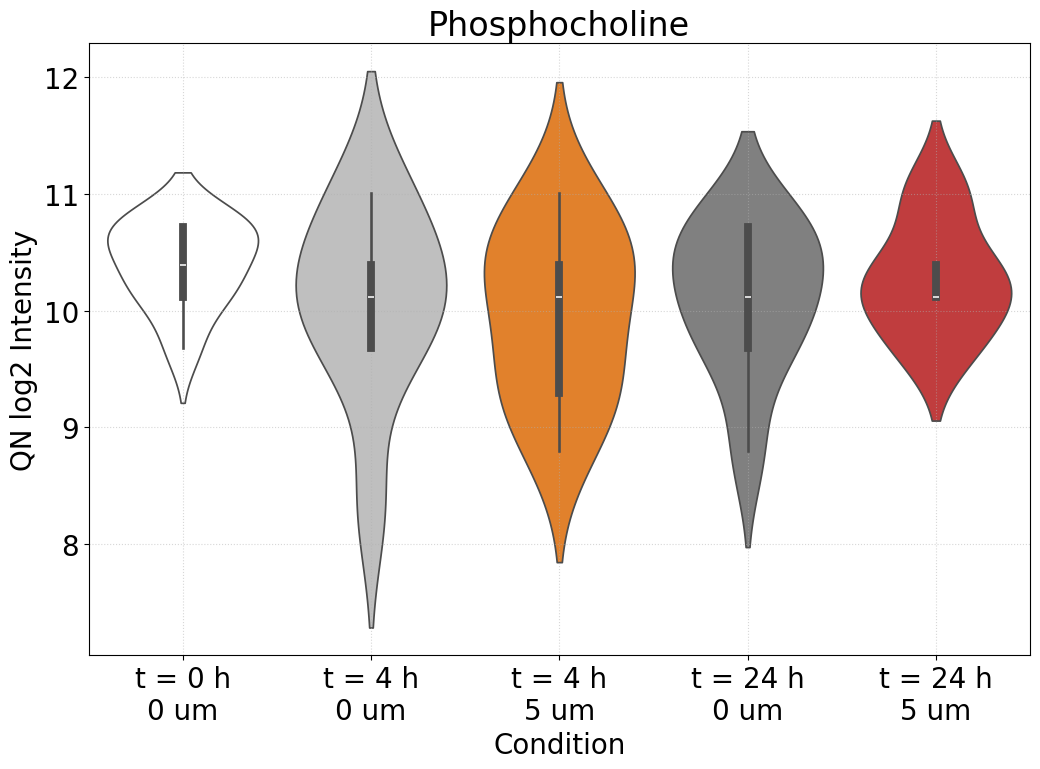


SAMe
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


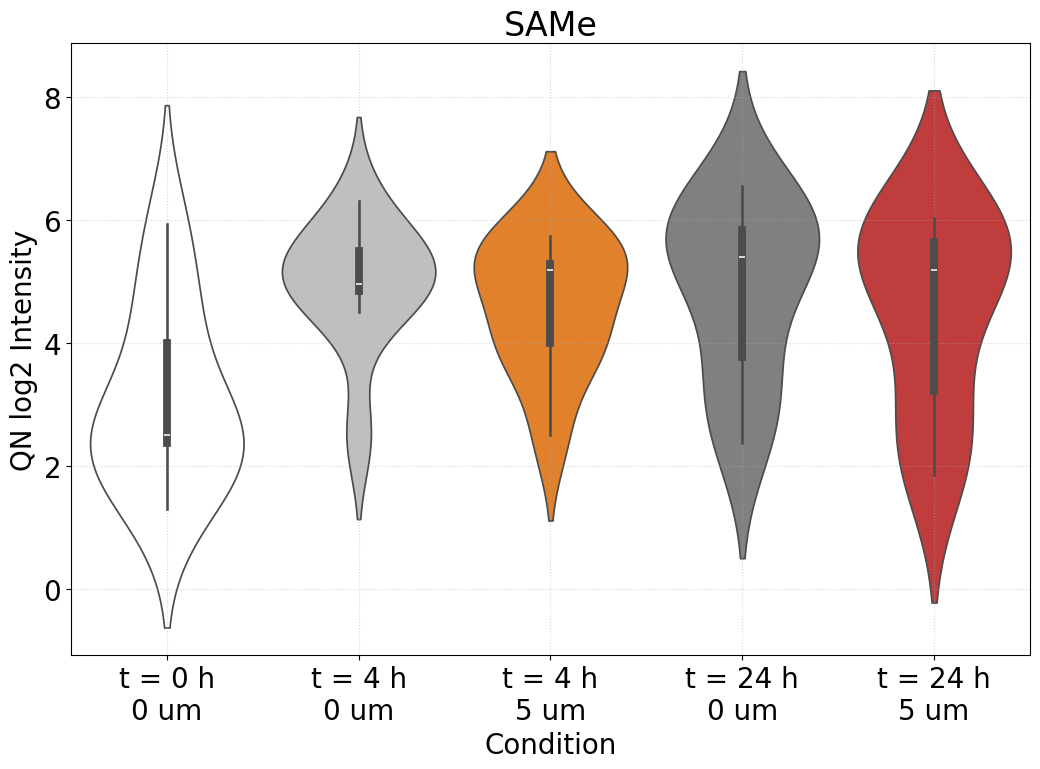


Thiamine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


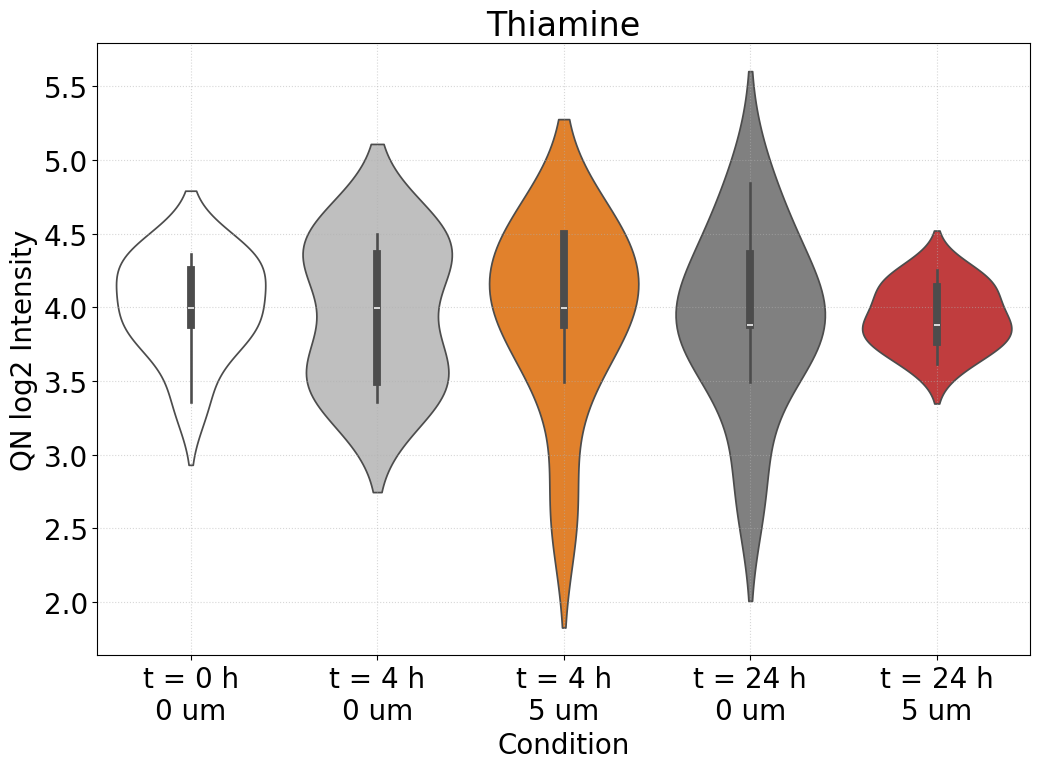


Carnitine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)
	 significance at 24 h


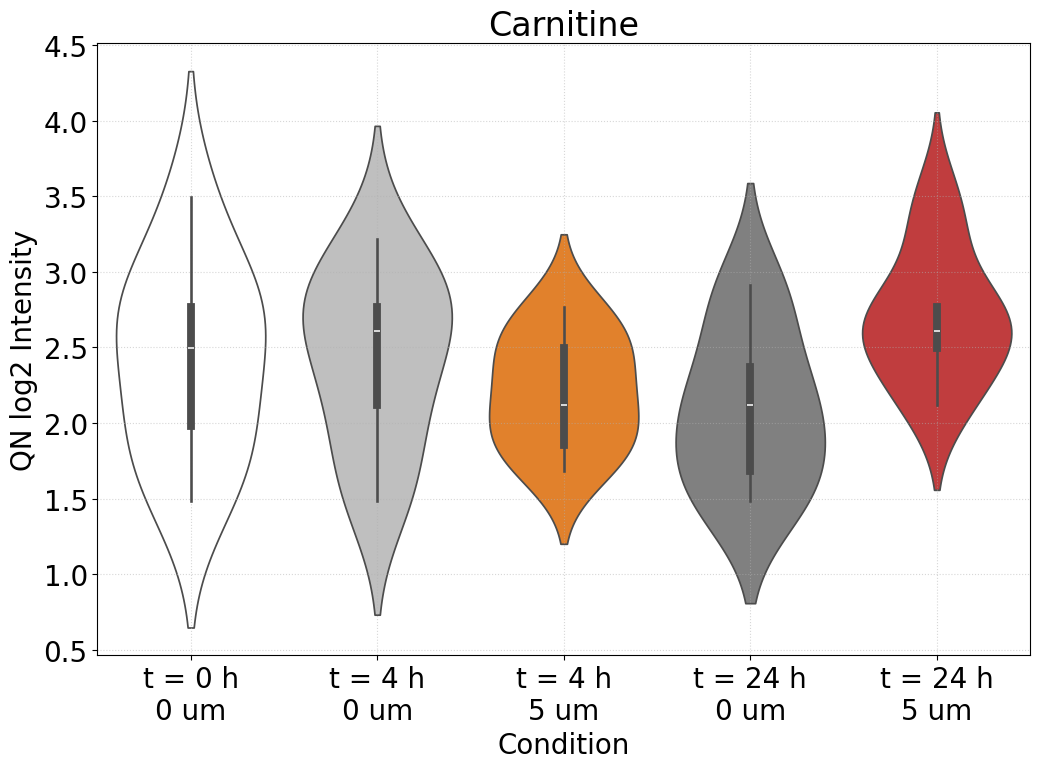


Acetyl-carnitine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


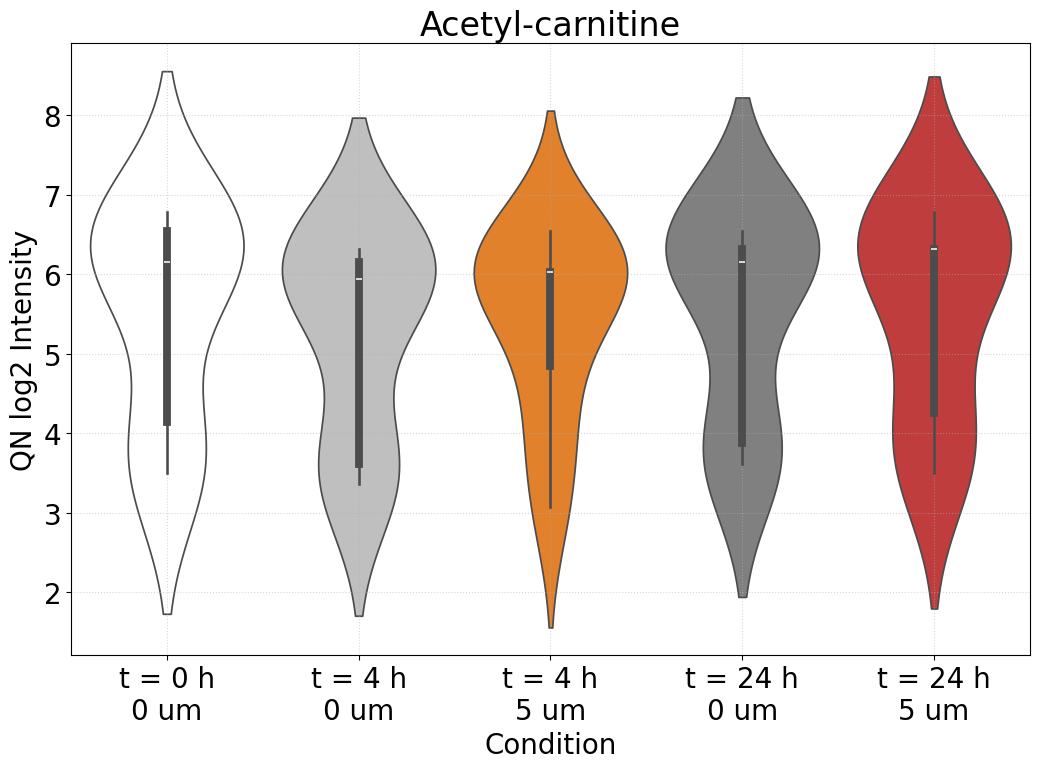


C3 Carnitine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


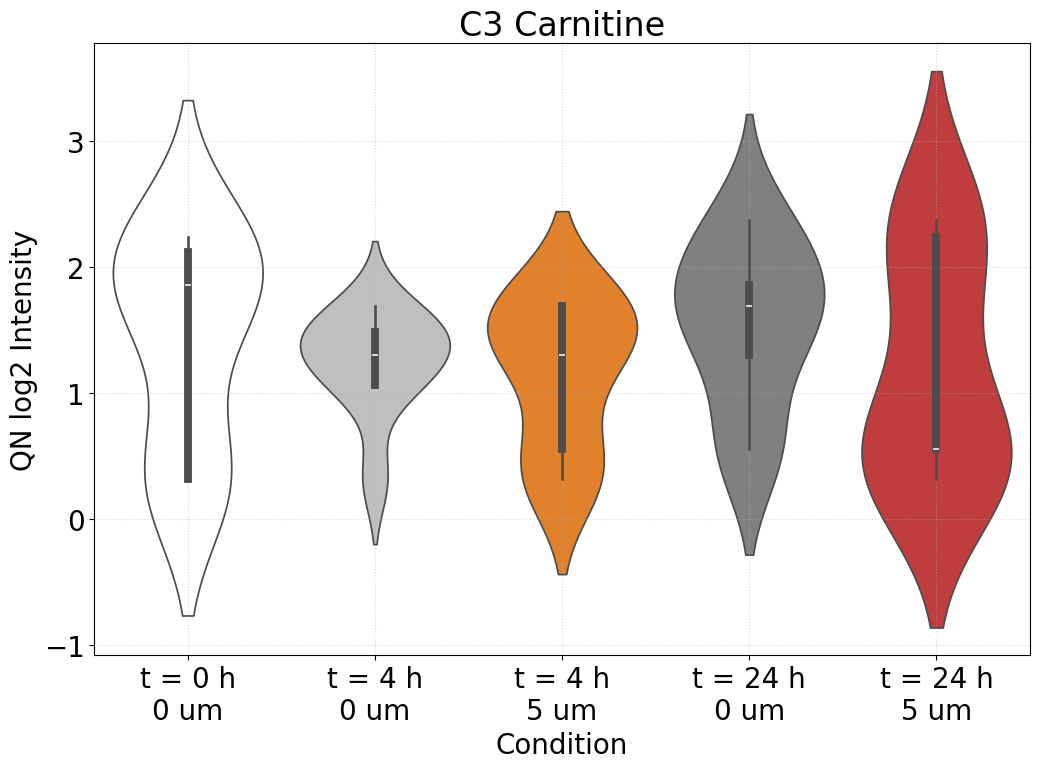


Choline
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


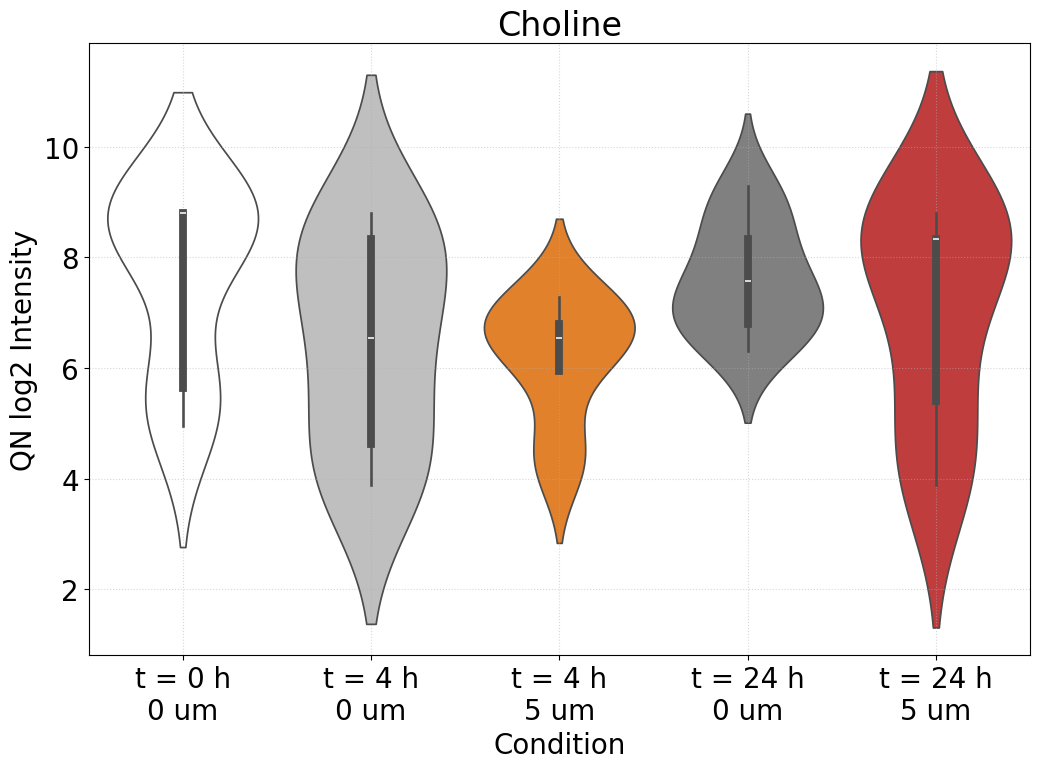


sn-Glycero-3-phosphocholine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


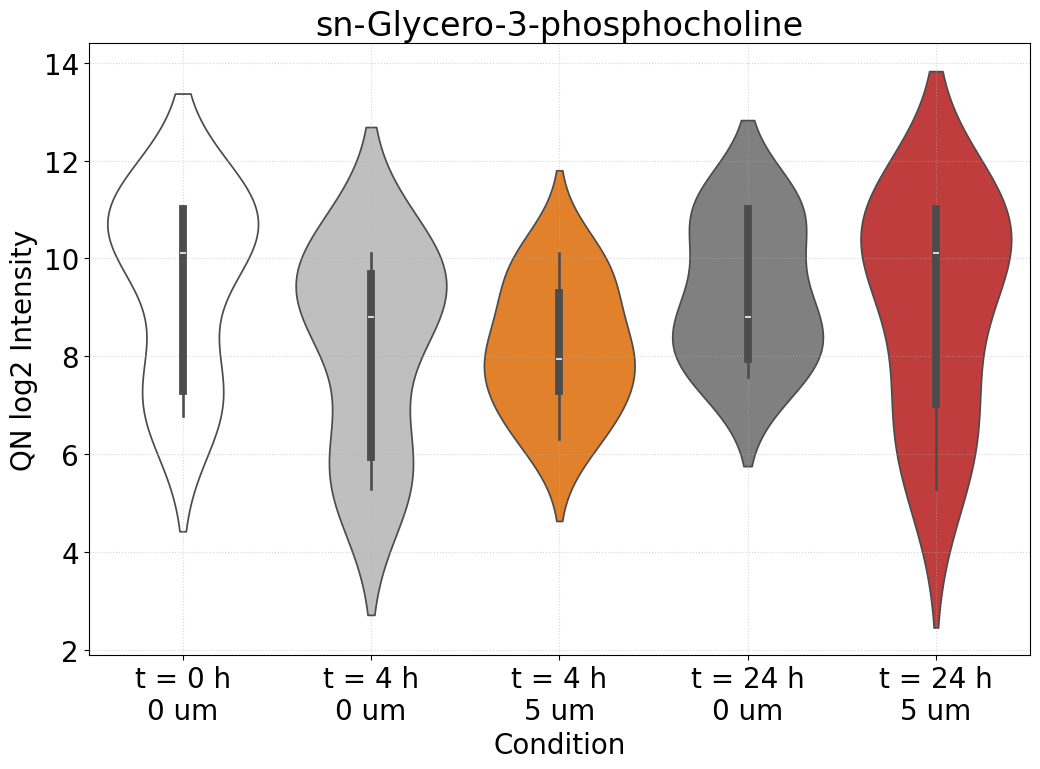


LPC 14:0
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



LPC 16:0
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



LPC 18:2
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


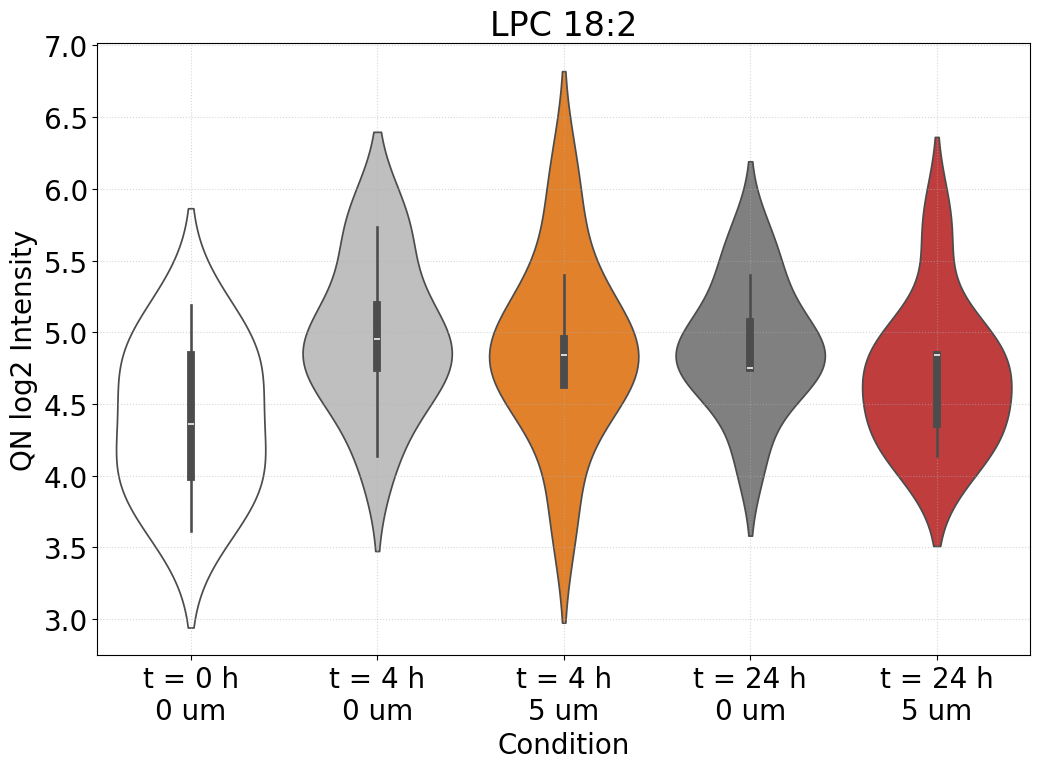


LPC 20:3
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


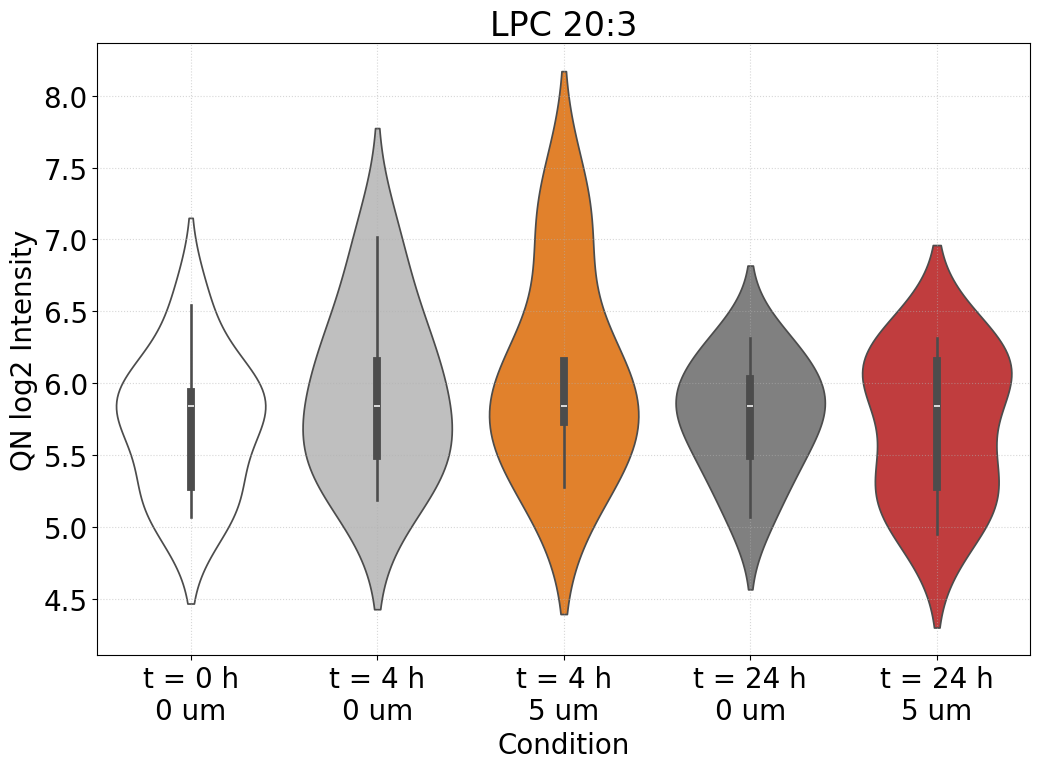


LPC 20:4
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


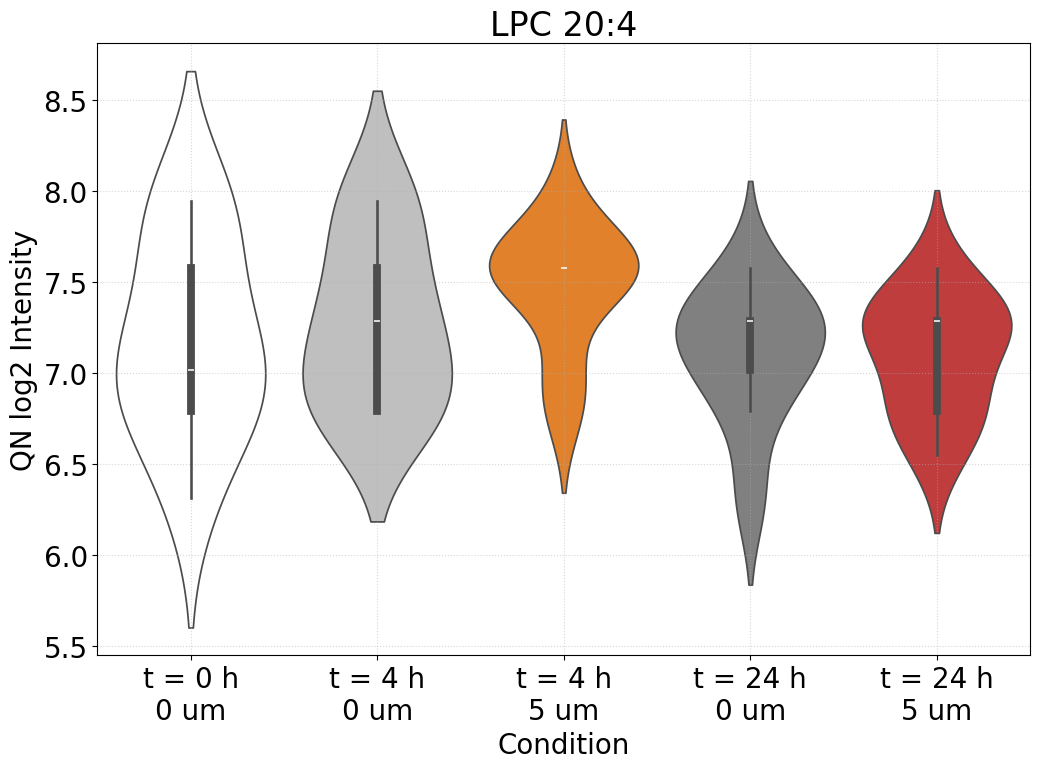


LPC 22:6
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


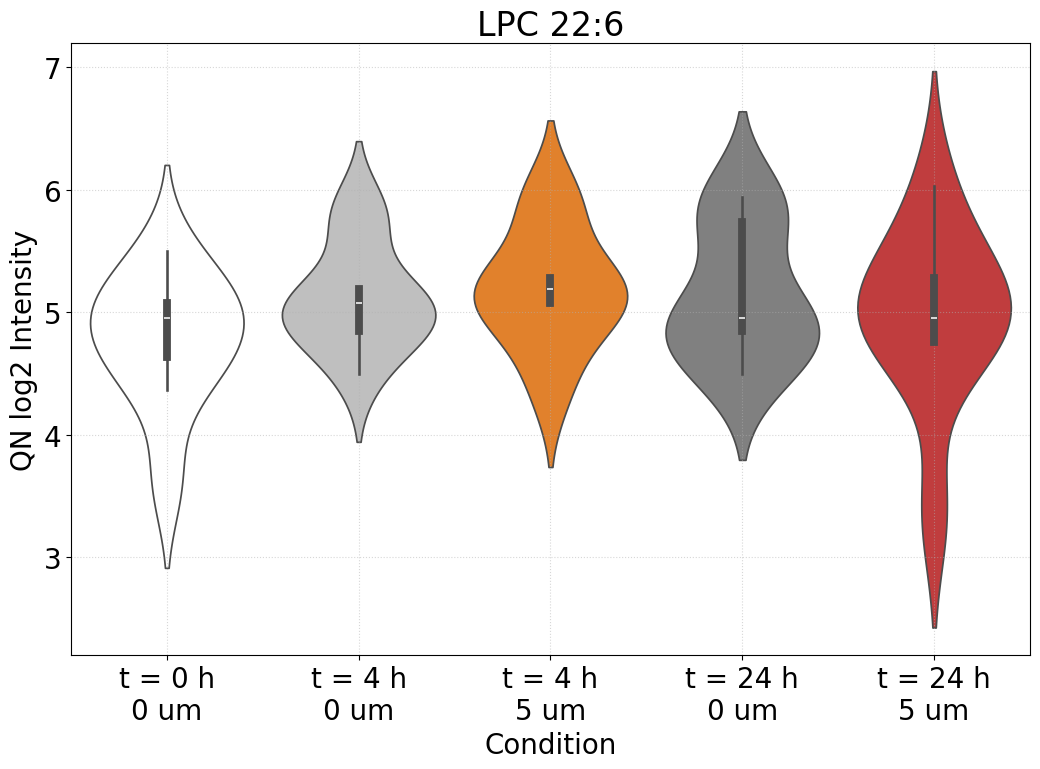


LPE 18:0
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


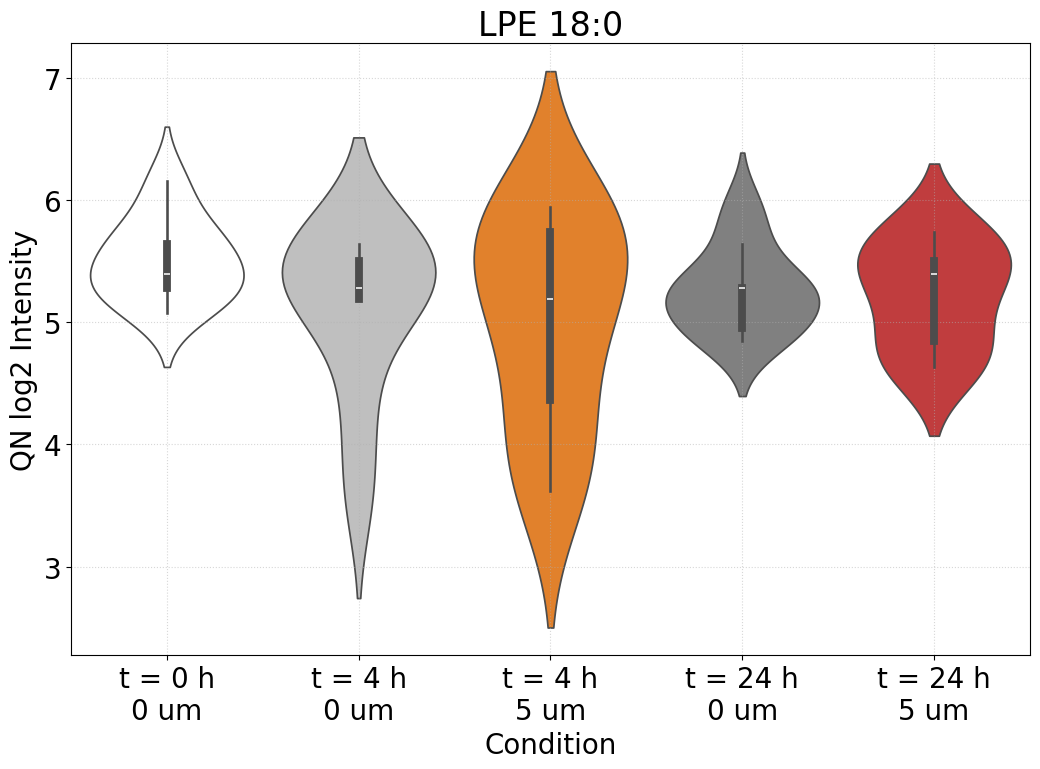


LPE 18:1
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


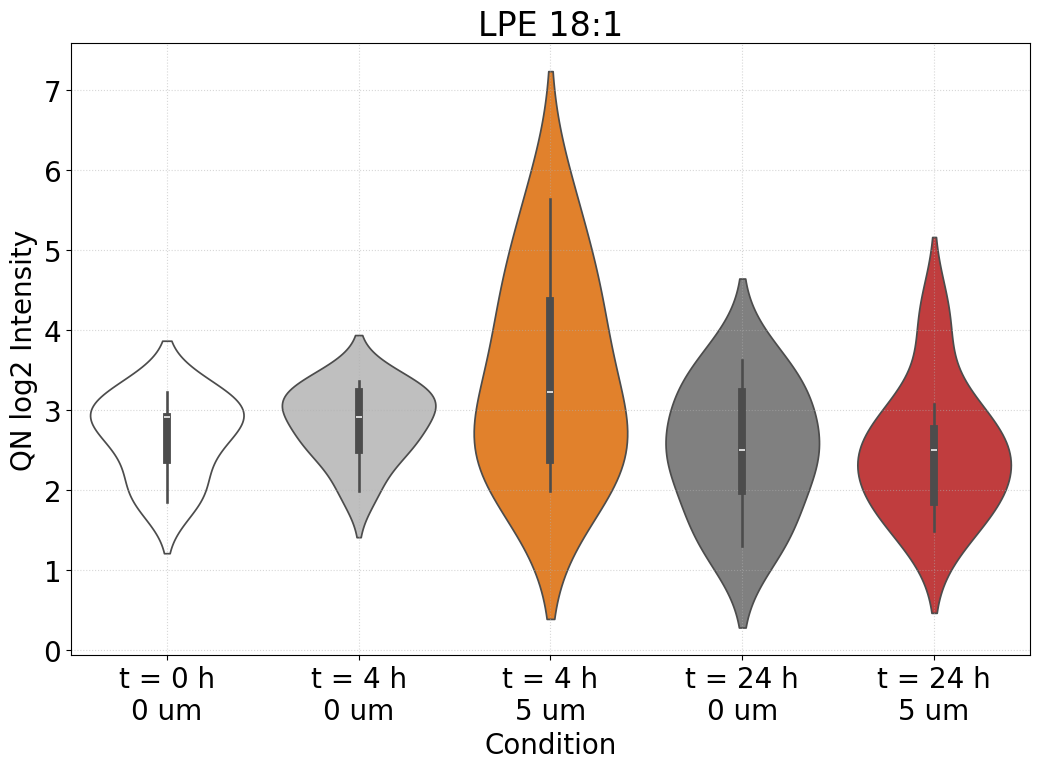


LPE 20:4
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


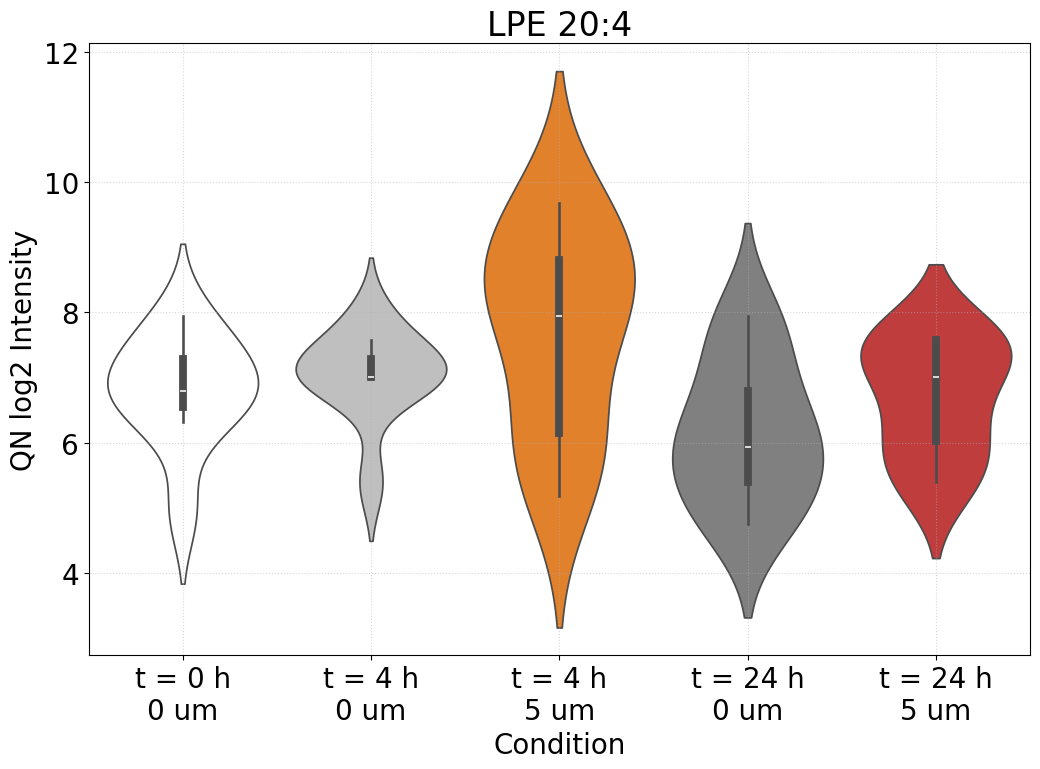


LPE 22:4
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


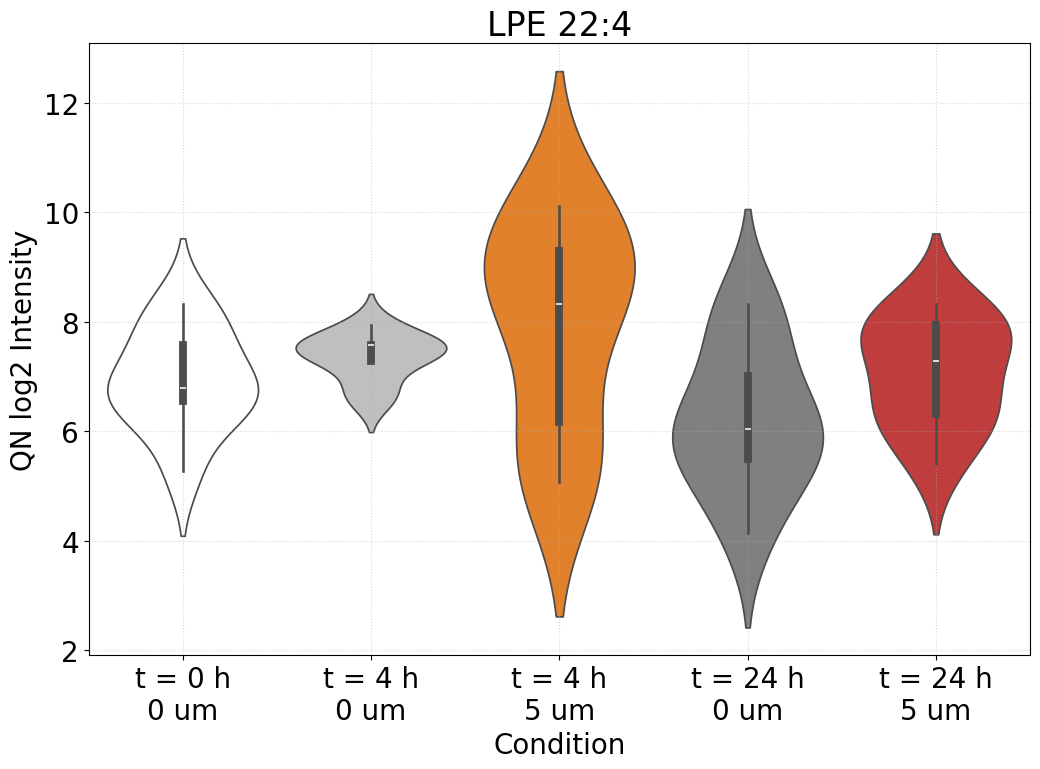


LPE 22:6
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


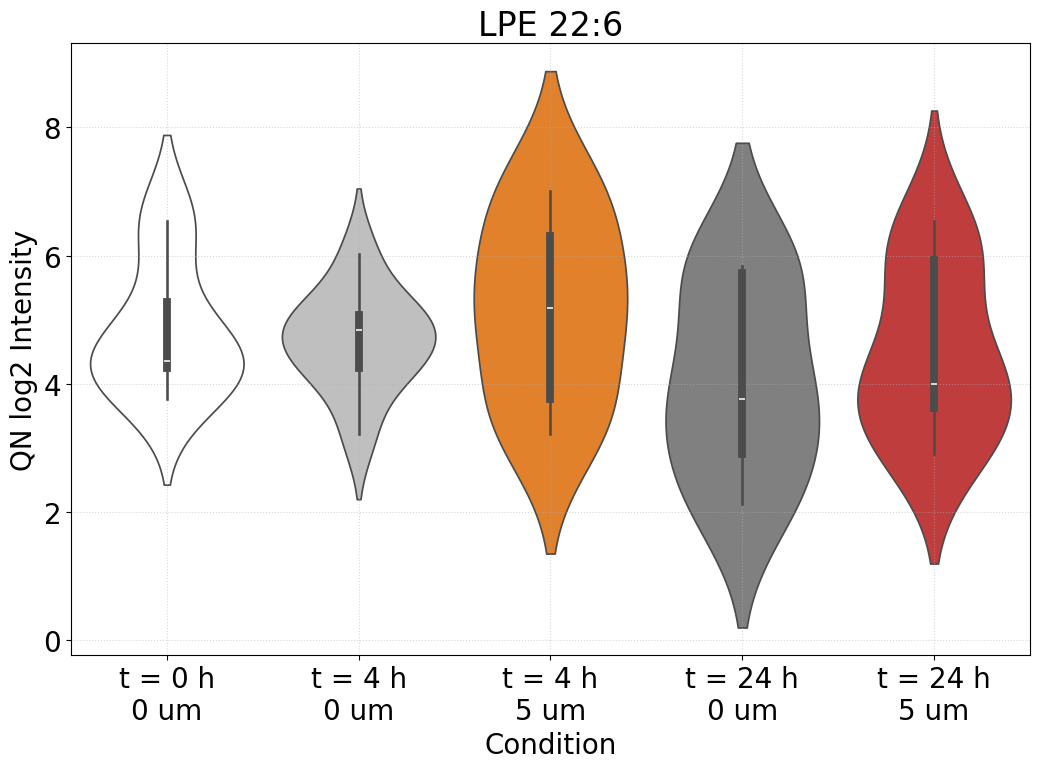


Sphingosine-1-phosphate
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


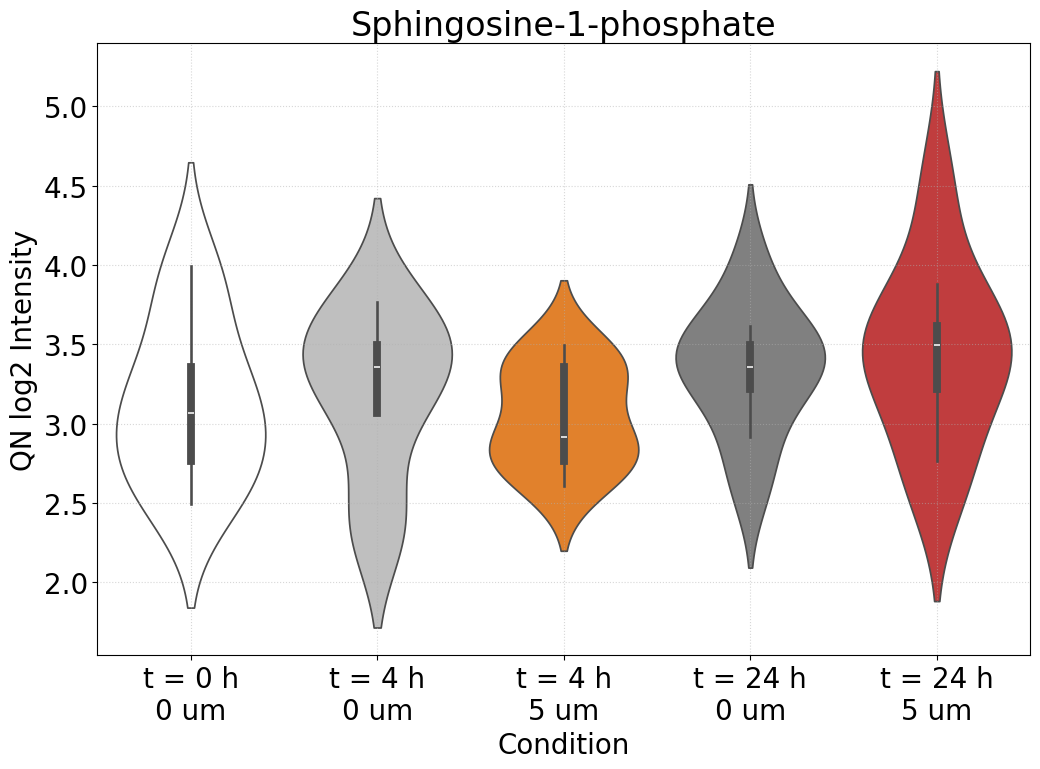


Hydroxyproline
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)
	 significance at 4 h


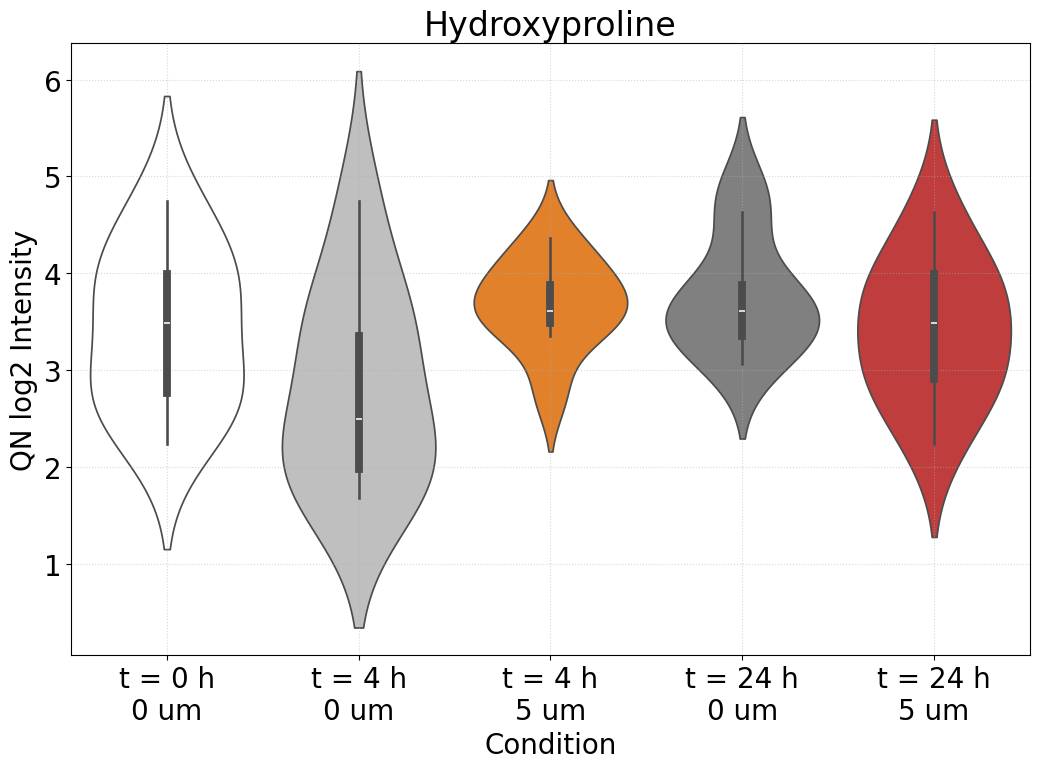


Xanthine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


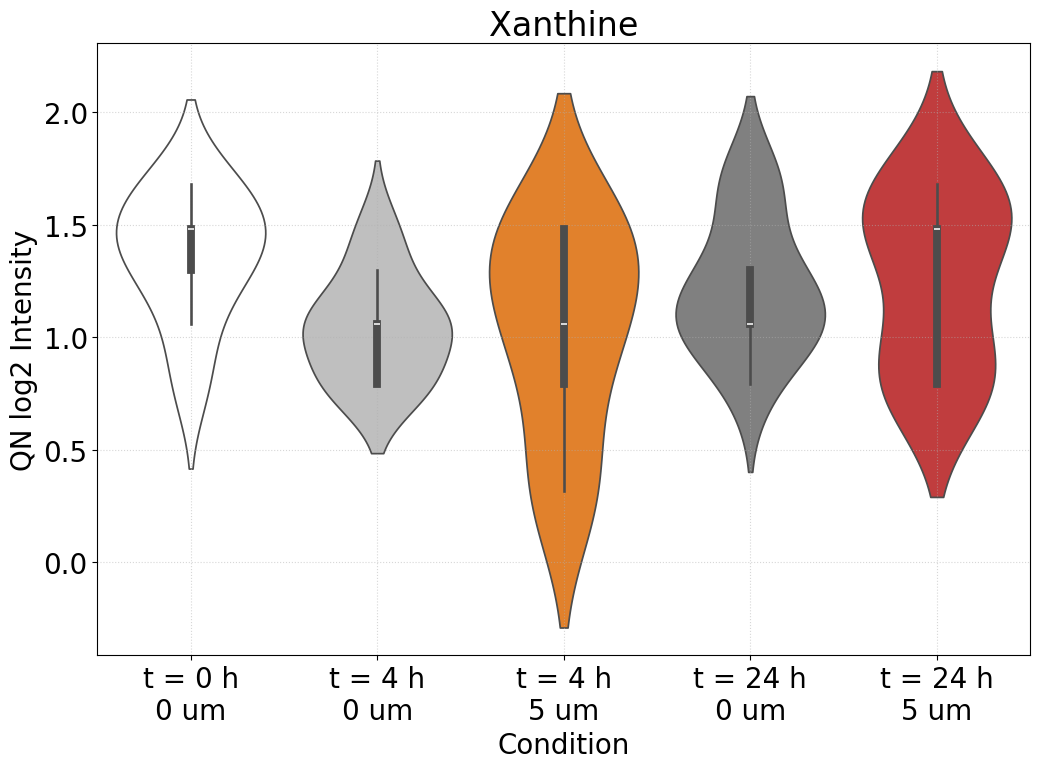


Cysteineglycine disulfide
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


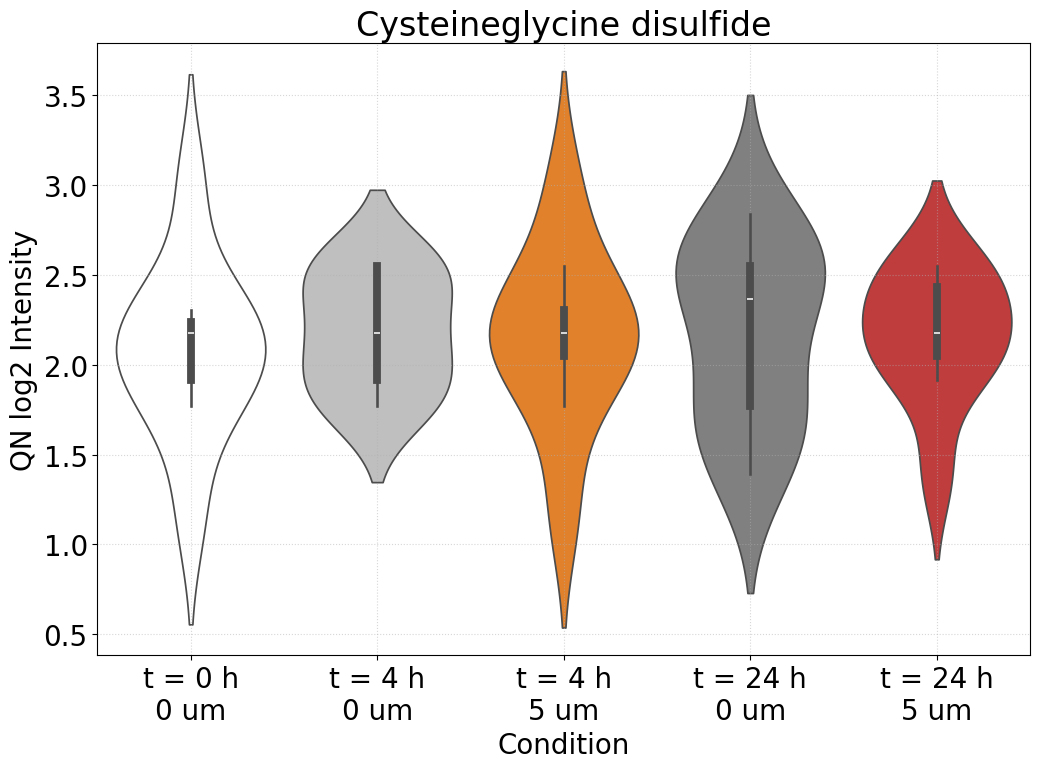


PGH2_335_Oxylipin_C20H32O5
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


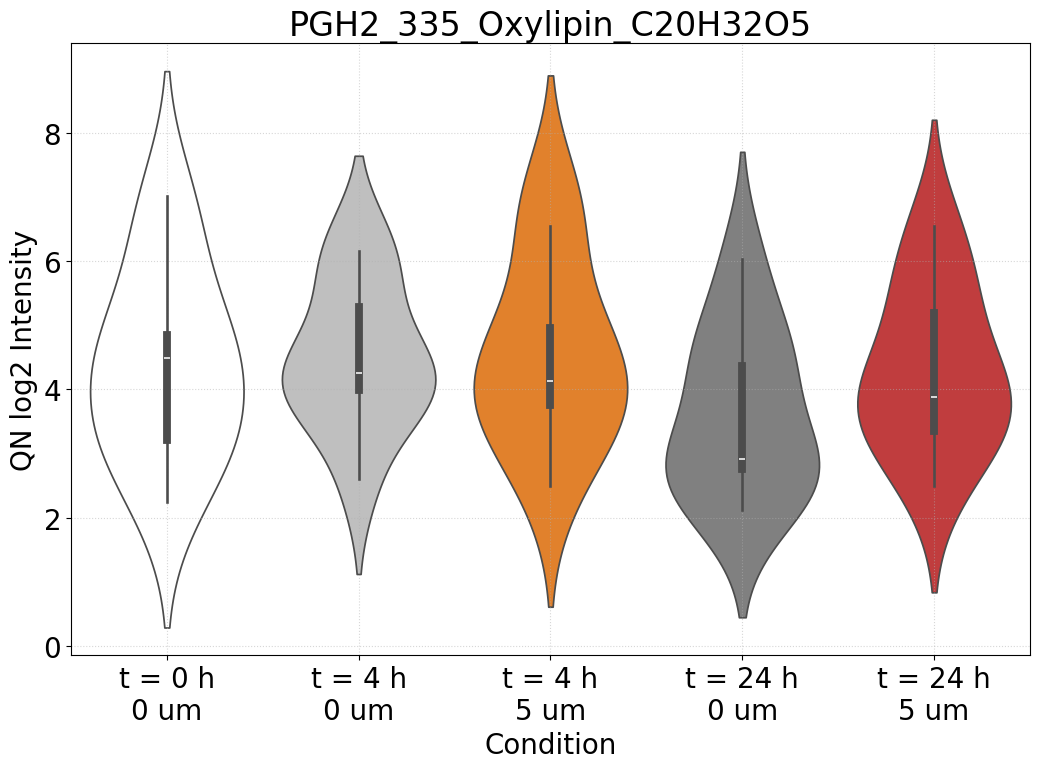


Glutathione oxidized
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)



Fragment Degradation Glutathione
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


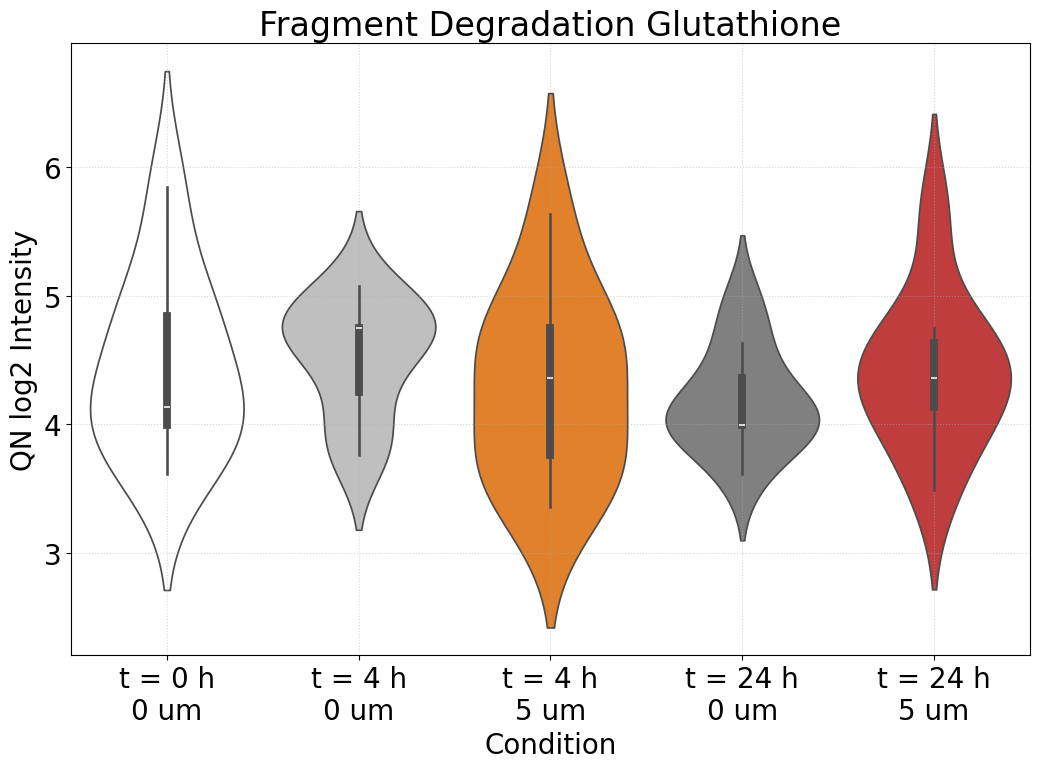


Glutathione reduced
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


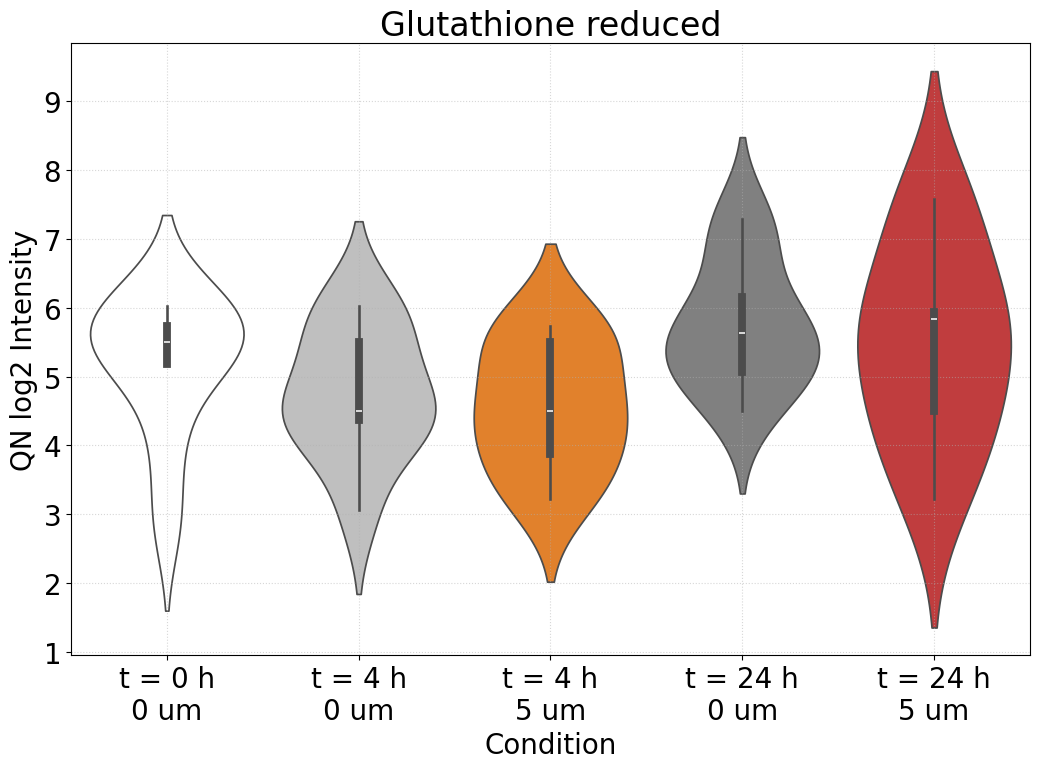


Riboflavin
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


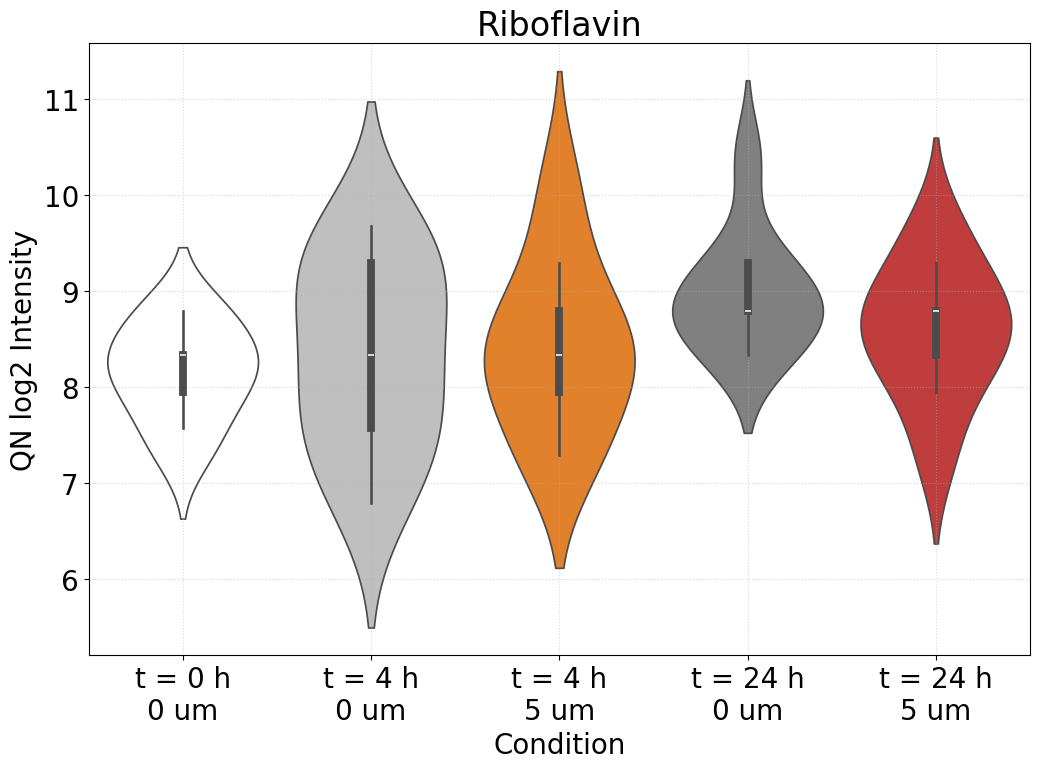


Lactoylglutathione
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


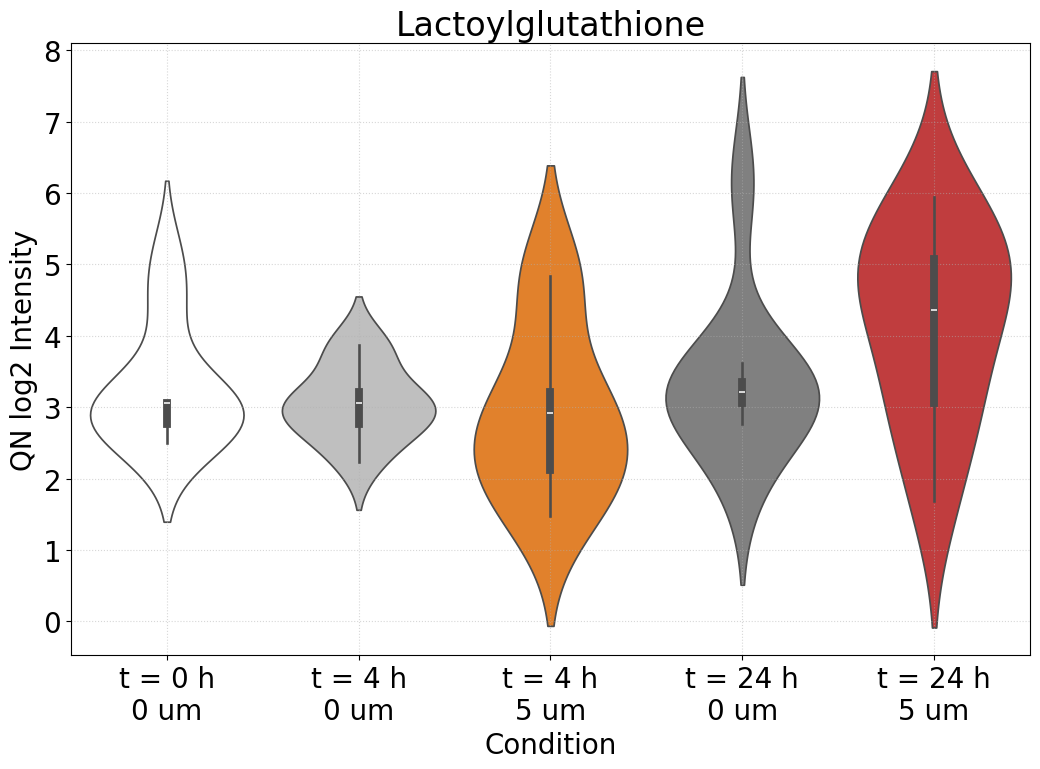


Glycogen
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


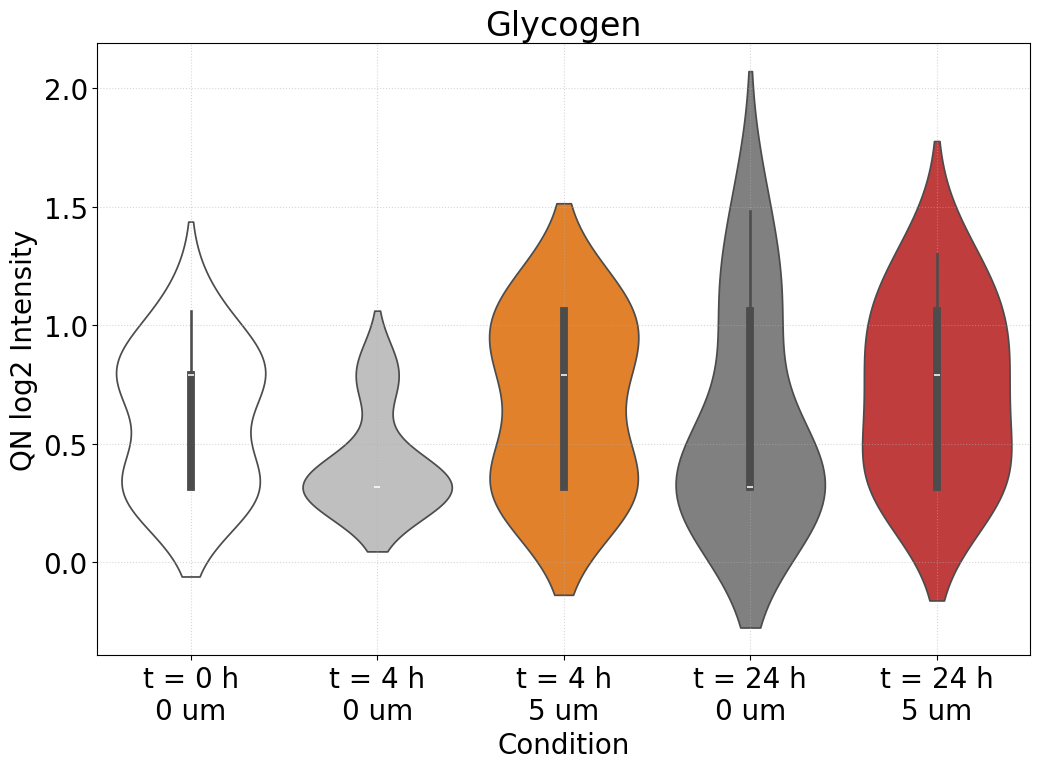


Cysteine Glutathione disulfide
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


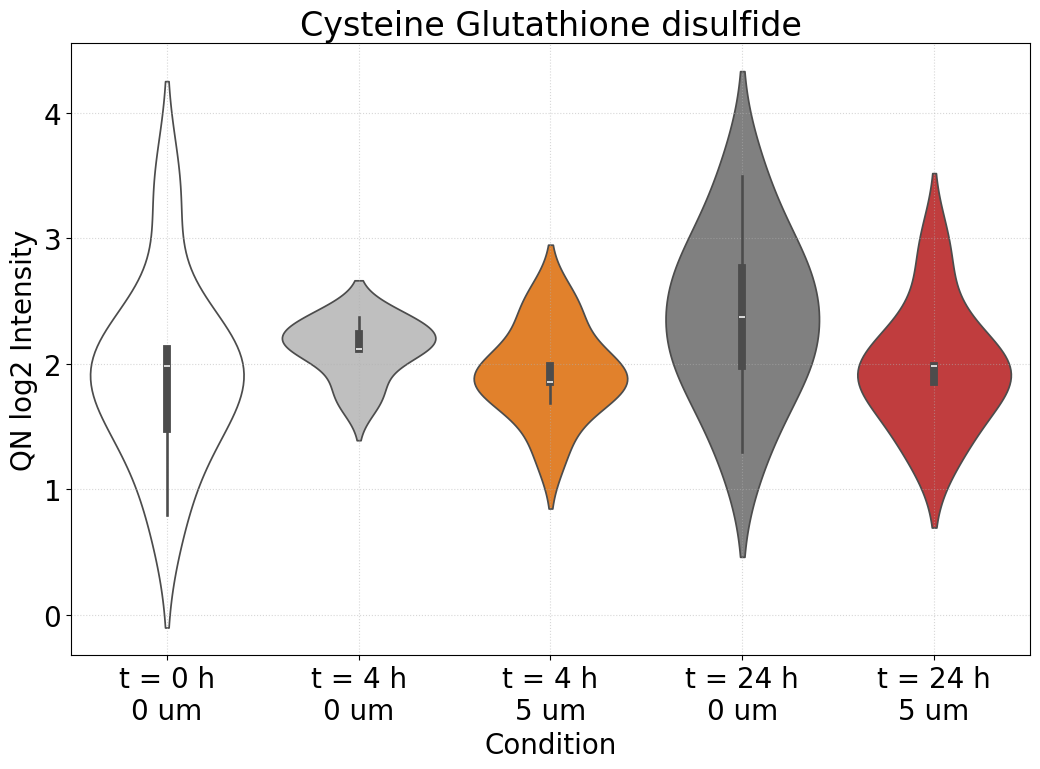


Cysteineglycine disulfide.1
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


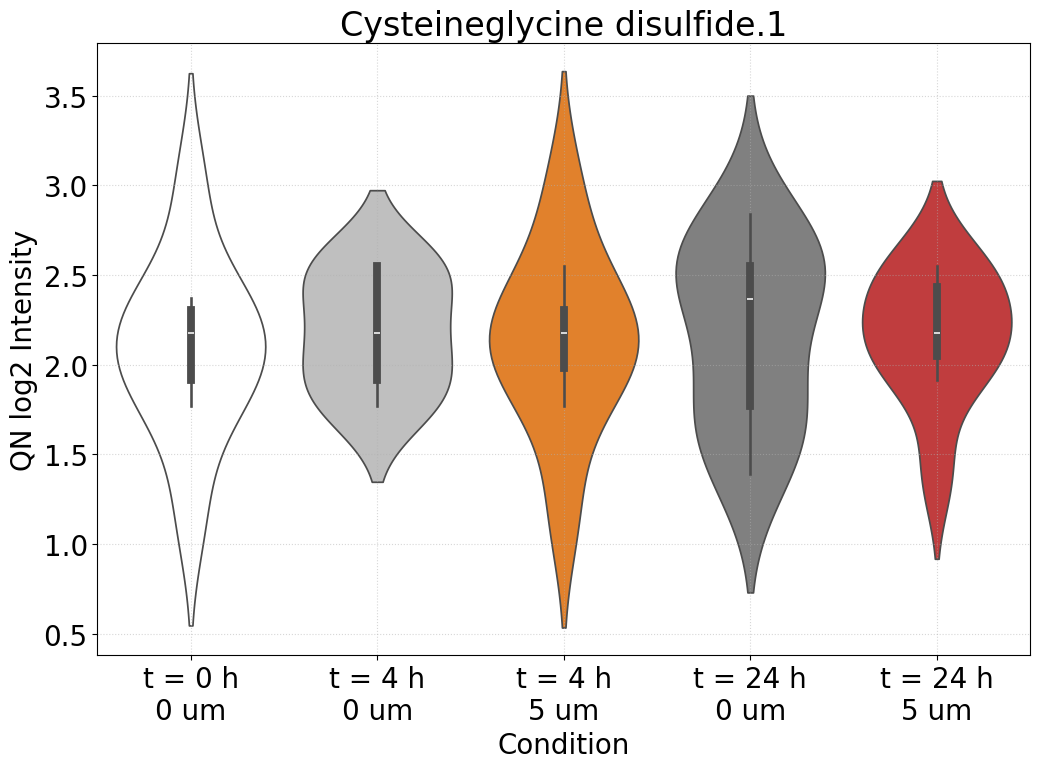


pipecolic acid
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


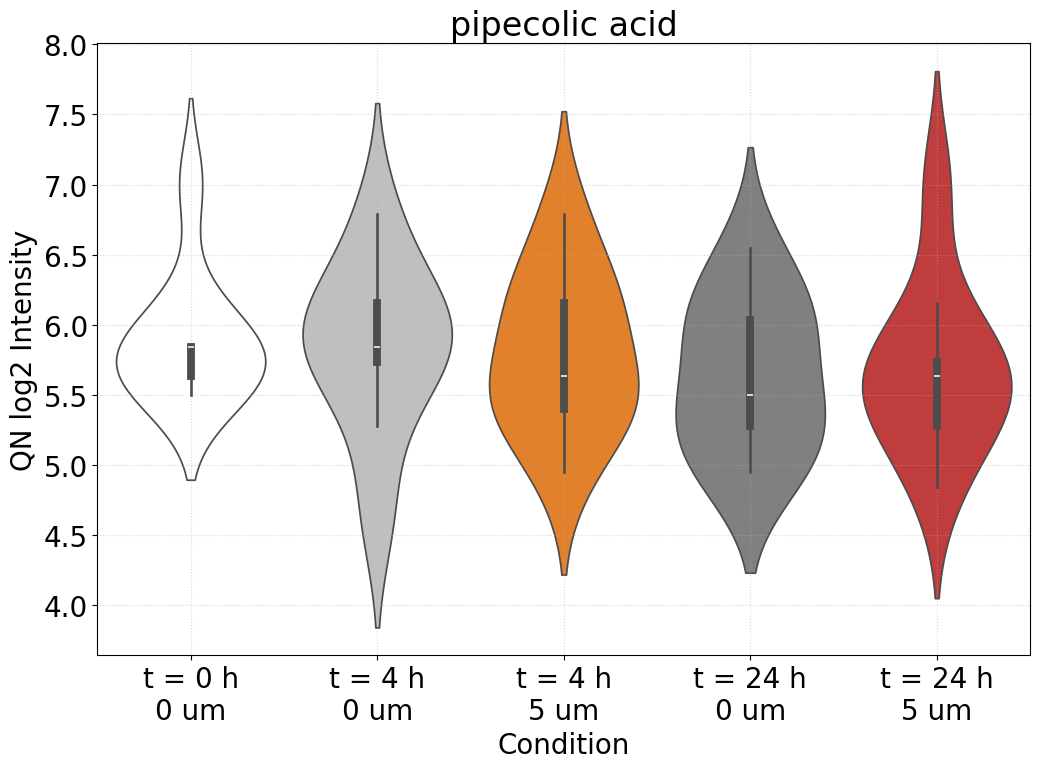


nAcSpermidine
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


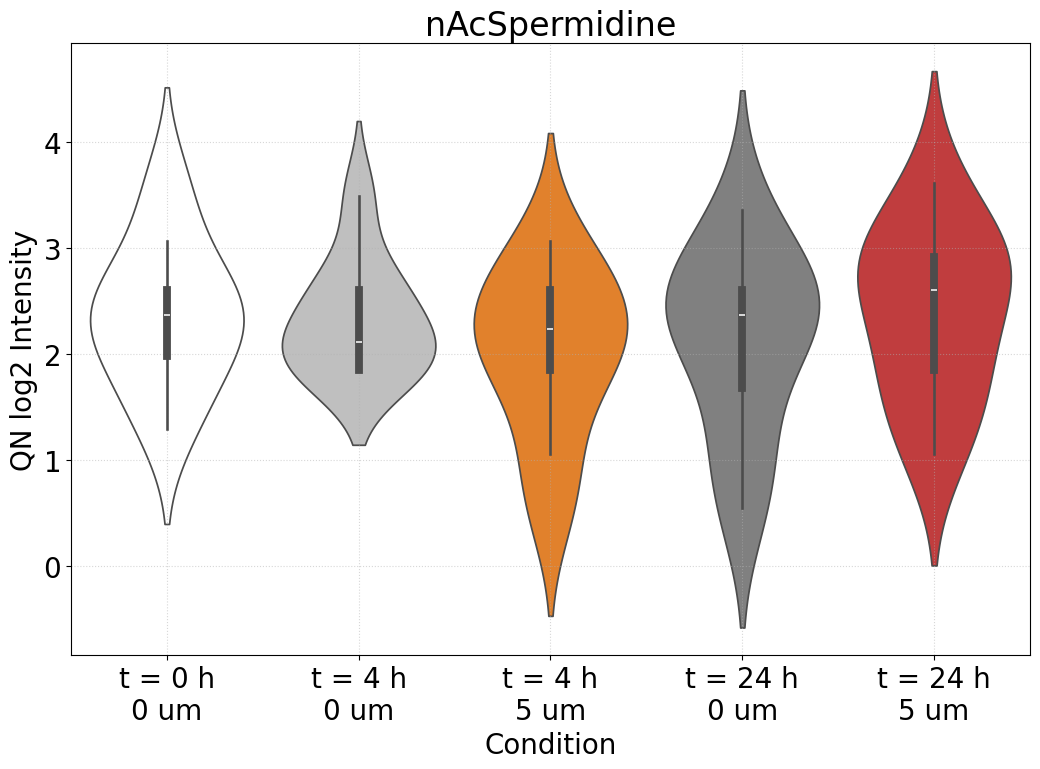


AMP
	 (0, 0)
	 (0, 4)
	 (5, 4)
	 (0, 24)
	 (5, 24)


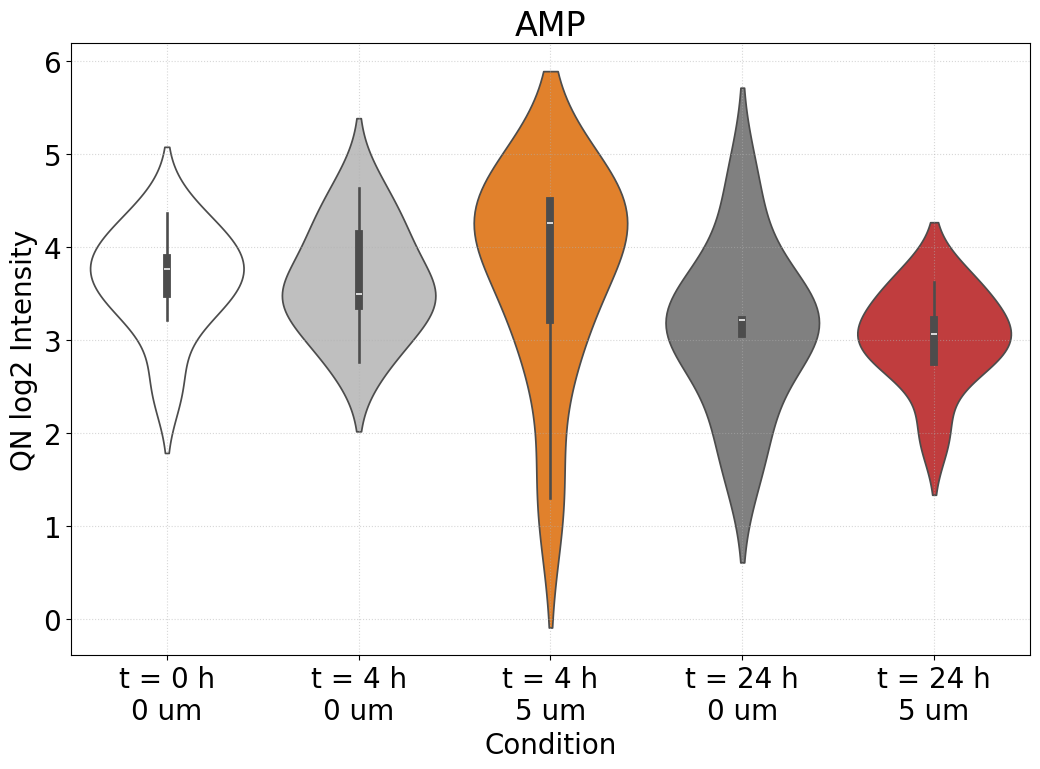

In [28]:
# plot the dots
# go one by one, compute three tests 

conditions = [(0, 0), (0, 4), (5, 4), (0, 24), (5, 24)]
metabolites = wdf.index

for metabolite in metabolites:
    print(metabolite)
    all_intensities = []
    for condition in conditions:
        
        print('\t', condition)
        
        a = metadata['µM catech'] == condition[0]
        b = metadata['Timepoint'] == condition[1]
        rules = a & b
        info = metadata[rules]
        labels = [label for label in info.index if '008' in label]
        #print(len(labels), labels)
        if len(labels) != 9:
            print('ERROR!!!!!!!!')
        intensities = wdf.loc[metabolite, labels].values
        #print(intensities)
        all_intensities.append(intensities)

    # t-test
    results4 = scipy.stats.ttest_ind(all_intensities[1], all_intensities[2])
    results24 = scipy.stats.ttest_ind(all_intensities[3], all_intensities[4])

    if results4.pvalue < 0.05:
        print('\t significance at 4 h')
    if results24.pvalue < 0.05:
        print('\t significance at 24 h')
    
    # plot distributions
    seaborn.violinplot(all_intensities, palette=['white', '0.75', 'tab:orange', '0.5', 'tab:red'])
    matplotlib.pyplot.xticks([0, 1, 2, 3, 4], ['t = 0 h\n0 um', 't = 4 h\n0 um', 't = 4 h\n5 um', 't = 24 h\n0 um', 't = 24 h\n5 um'])
    matplotlib.pyplot.title(metabolite)
    matplotlib.pyplot.grid(alpha=1/2, ls=':')
    matplotlib.pyplot.ylabel('QN log2 Intensity')
    matplotlib.pyplot.xlabel('Condition')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    print()

In [ ]:
# visualize violin plots for each metabolite across all conditions. Do a test on specific conditions.
# subset significant ones for heatmap. Consider one for lipids and another one for metabolites in the manuscript (consider comparing replicate-wise)

In [ ]:
# heatmap

In [ ]:

conditions = [(0, 0), (0, 4), (5, 4), (0, 24), (5, 24)]
metabolites = wdf.index

def log2FC_retreiver(metabolite, treatment, timepoint):
    log2FCs = []
    for biorep in [1, 2, 3]:
        a = (metadata['µM catech'] == treatment)
        b = (metadata['Timepoint'] == timepoint)
        c = (metadata['BioReplicate'] == biorep)
        rules = a & b & c
        info = metadata[rules]
        if info.shape[0] != 3:
            print('error')
        labels = info.index
        intensities = wdf.loc[metabolite, labels]
        sample_value = numpy.mean(intensities)

        a = (metadata['µM catech'] == 0)
        b = (metadata['Timepoint'] == timepoint)
        c = (metadata['BioReplicate'] == biorep)
        rules = a & b & c
        info = metadata[rules]
        if info.shape[0] != 3:
            print('error')
        labels = info.index
        intensities = wdf.loc[metabolite, labels]
        reference_value = numpy.mean(intensities)

        log2FC = sample_value - reference_value
        log2FCs.append(log2FC)
        
        print(biorep, labels, sample_value, reference_value)
    return log2FCs, info

for metabolite in metabolites[:3]:
    print(metabolite)
    for condition in conditions:
        print('\t', condition)
        log2FCs, info = log2FC_retreiver(metabolite, condition[0], condition[1])
        print('\t', condition, log2FCs)